## Introduction
This file is concerned with the first asssignment in the ST 443 group project. The task is to classify the observation to one of the eight vegetation classes based on the reflectance values for each pixel in the i-th wavelenght band, i $ \ \in \ \{1, 2, \ldots, 218\}$. We will start with T1.1, which is concerned with data visualization and understanding the distribution of the features, and the target.

## Data Preparation and Imports

### Import

In [273]:
#Imports from the standard library
import sys

#Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_validate, StratifiedKFold


### Read the zipped csv file

In [274]:
#Replace the path with the absolute path of your file
data1=pd.read_csv('data-1.csv.gz')

In [275]:
#Subsampled Data for SVM and KNN only, as full data cause memory breakdown

data1_1 = data1.sample(30000, random_state=42)


## Task 1.1: Data Visualization and summary statistics

Inspect the dataset

In [276]:
#Shape of the dataframe
print(f"\n Number of Rows: {data1.shape[0]} \n Number of Columns: {data1.shape[1]}")

print(f"\n Number of Rows (sampled data): {data1_1.shape[0]} \n Number of Columns: {data1_1.shape[1]}")


 Number of Rows: 215604 
 Number of Columns: 223

 Number of Rows (sampled data): 30000 
 Number of Columns: 223


In [277]:
#Datatypes of all the columns in the dataset
data1.dtypes

land_type       object
p_x              int64
p_y              int64
Band_1         float64
Band_2         float64
                ...   
Band_216       float64
Band_217       float64
Band_218       float64
rgb_hex         object
overlay_hex     object
Length: 223, dtype: object

In [278]:
#Information about the dataset
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215604 entries, 0 to 215603
Columns: 223 entries, land_type to overlay_hex
dtypes: float64(218), int64(2), object(3)
memory usage: 366.8+ MB


In [279]:
#Look at the first 5 entries
data1.head()

,land_type,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,...,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218,rgb_hex,overlay_hex
0,valley floor / meadow,0,0,0.0174,0.0131,0.0108,0.0133,0.0158,0.0144,0.0151,...,0.0237,0.0231,0.0224,0.0246,0.0255,0.0174,0.0234,0.0147,#030B05,#25C77140
1,valley floor / meadow,1,0,0.0180,0.0124,0.0116,0.0143,0.0154,0.0136,0.0151,...,0.0289,0.0275,0.0288,0.0293,0.0286,0.0211,0.0229,0.0176,#040A09,#25C77140
2,valley floor / meadow,2,0,0.0151,0.0150,0.0113,0.0158,0.0167,0.0158,0.0163,...,0.0358,0.0319,0.0355,0.0274,0.0303,0.0232,0.0282,0.0181,#08110B,#25C77140
3,valley floor / meadow,3,0,0.0172,0.0149,0.0095,0.0156,0.0154,0.0169,0.0176,...,0.0310,0.0294,0.0307,0.0238,0.0304,0.0232,0.0247,0.0087,#0C160C,#25C77140
4,valley floor / meadow,4,0,0.0184,0.0149,0.0143,0.0189,0.0174,0.0174,0.0182,...,0.0428,0.0372,0.0407,0.0344,0.0415,0.0287,0.0317,0.0176,#0E180C,#25C77140


Summary statistics

In [280]:
#Summary statistics of the float columns
data1.select_dtypes(include = "float64").describe()

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_209,Band_210,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218
count,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,...,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000
mean,0.095601,0.094335,0.095621,0.099081,0.100492,0.101252,0.102764,0.104476,0.105329,0.107272,...,0.110929,0.108438,0.108563,0.105381,0.105773,0.100424,0.099806,0.095834,0.092850,0.086839
std,0.164291,0.163833,0.165067,0.166807,0.167414,0.167216,0.167939,0.168141,0.168005,0.168948,...,0.059208,0.059431,0.059182,0.059277,0.058764,0.057765,0.056946,0.057251,0.054999,0.056024
min,-0.012000,-0.012600,-0.011900,-0.008800,-0.009300,-0.009000,-0.007700,-0.007500,-0.006600,-0.005300,...,0.007400,0.005700,0.006900,0.003600,0.006800,0.002400,0.004100,0.001100,0.000100,-0.010000
25%,0.022600,0.020600,0.020000,0.022900,0.023400,0.023800,0.024500,0.025500,0.025900,0.026900,...,0.058600,0.055700,0.056000,0.052500,0.053500,0.048900,0.048900,0.044400,0.043600,0.036300
50%,0.037800,0.036800,0.037700,0.040600,0.041600,0.042200,0.043400,0.045300,0.046200,0.047900,...,0.101100,0.098200,0.098200,0.094900,0.095000,0.089600,0.089000,0.085100,0.082300,0.076000
75%,0.078000,0.078000,0.081100,0.083800,0.086100,0.087700,0.090000,0.092700,0.094200,0.096900,...,0.157700,0.155500,0.155300,0.152500,0.152300,0.146400,0.145100,0.141500,0.136700,0.132000
max,1.581000,1.574100,1.587100,1.595900,1.603600,1.605300,1.609500,1.613800,1.608800,1.608500,...,0.453700,0.446600,0.453600,0.449000,0.446700,0.429900,0.435100,0.433000,0.429100,0.411200


Missing Values

In [281]:
#Missing values
missing_features = data1.select_dtypes(include = "float64").isna().sum().sum()
missing_target = data1['land_type'].isna().sum()
print(f"Total missing values in the feature space: {missing_features}")
print(f"Total missing target values: {missing_target}")

Total missing values in the feature space: 0
Total missing target values: 0


Duplicates

In [282]:
#Duplicates check
data1[data1.duplicated() == True]

,land_type,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,...,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218,rgb_hex,overlay_hex


No duplicates in this dataset. We can check for invalid values. Reflectance values should be in $[0,1]$.

In [283]:
bands = [col for col in data1.columns if col.startswith("B")]
print("Negative reflectance values:", (data1[bands] < 0).sum().sum())
print("Reflectance values > 1:", (data1[bands] > 1).sum().sum())

Negative reflectance values: 20000
Reflectance values > 1: 39777


There are invalid values in the dataset, so we should clip them, such that the minimum value is 0, and the maximum value is 1.

In [284]:
#Clip the extreme values
data1[bands] = data1[bands].clip(lower=0, upper=1)
print("After clipping:")
print("Min reflectance:", data1[bands].min().min())
print("Max reflectance:", data1[bands].max().max())

After clipping:
Min reflectance: 0.0
Max reflectance: 1.0


Function to check for outliers based on the Z-scores.

In [285]:
def outlier_check(df, cols, z):
    z_score = np.abs((df[cols] - df[cols].mean()) / df[cols].std())
    outliers_df = df[np.any(z_score > z, axis = 1)]
    return outliers_df.shape[0]

We can check for values of 3 standard deviations away from mean to identify outliers.

In [286]:
outliers_number = outlier_check(data1, bands, 3)
percentage_of_outliers = outliers_number/data1.shape[0] * 100
print(f"Percentage of outliers: {percentage_of_outliers}")

Percentage of outliers: 5.166416207491512


Very few outliers, and we were very severe in flagging them. Normally, we would not expect features to follow a normal distribution, so there would be less outliers. No reason to drop them. We should check for imbalance by looking at the distribution of the vegetation classes.

Distribution of vegetation classes

In [287]:

# Check distribution of vegetation classes to indentify potential imbalance(may affect classification later)
class_counts = data1["land_type"].value_counts()
class_percent = data1["land_type"].value_counts(normalize=True) * 100

balance_df = pd.DataFrame({
    "Count": class_counts,
    "Percentage": class_percent.round(2)
}).reset_index().rename(columns={"index": "Land Type"})


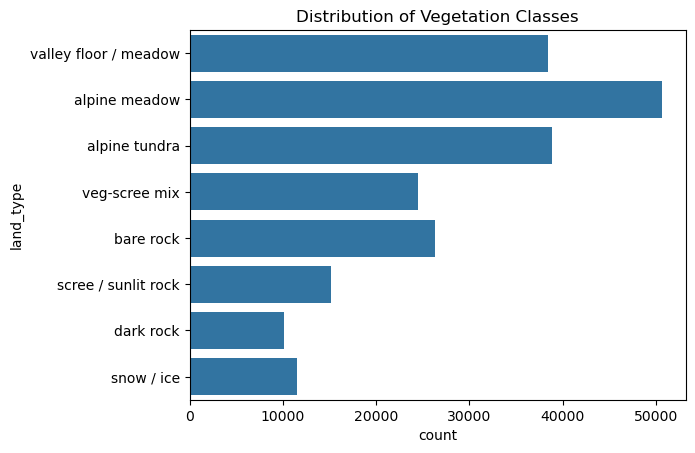

In [143]:
sns.countplot(y="land_type", data=data1)
plt.title("Distribution of Vegetation Classes")
plt.show()

We can observe that the alpine meadopw is the most frequent vegetation class, with around a quarter of the observations classified in this class. Also, valley floor and alpine tundra are also quite prevalent, and about 58% of all the observations are classified into one of this vegetation types.

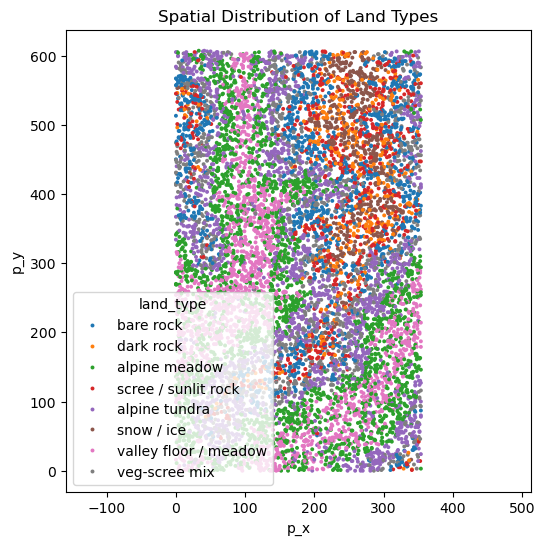

In [144]:
# Spatial distribution of land types (confirms figure 1 in the project description)
sample = data1.sample(10000, random_state=0)
plt.figure(figsize=(6,6))
sns.scatterplot(x="p_x", y="p_y", hue="land_type", data=sample, s=8, linewidth=0)
plt.title("Spatial Distribution of Land Types")
plt.axis("equal")
plt.show()

We should check if classes are separable in the spectral space.

In [145]:
# Check if classes are separable in spectral space
mean_spectra = data1.groupby("land_type")[bands].mean().T
mean_spectra

# Lines that differ strongly → those classes are spectrally separable → classification should work well.
# Overlapping lines → those classes are spectrally similar → may need nonlinear models (e.g. GBDT / SVM).
# Smoothness across bands → confirms that adjacent bands are highly correlated. Motivates PCA or regularisation later.

land_type,alpine meadow,alpine tundra,bare rock,dark rock,scree / sunlit rock,snow / ice,valley floor / meadow,veg-scree mix
Band_1,0.024688,0.039743,0.080441,0.304030,0.159906,0.685672,0.019638,0.061587
Band_2,0.022693,0.038833,0.080634,0.302374,0.160092,0.682125,0.017658,0.061243
Band_3,0.022188,0.039652,0.084026,0.305447,0.164070,0.686246,0.017099,0.063758
Band_4,0.024904,0.042673,0.086498,0.313921,0.168528,0.695479,0.019702,0.066261
Band_5,0.025452,0.043732,0.088971,0.316921,0.171769,0.698053,0.020141,0.067998
...,...,...,...,...,...,...,...,...
Band_214,0.061282,0.116874,0.182309,0.096537,0.147312,0.033467,0.040590,0.165270
Band_215,0.061064,0.115579,0.180517,0.097355,0.147048,0.034584,0.040641,0.163483
Band_216,0.056553,0.111538,0.177277,0.094289,0.143883,0.031539,0.035999,0.159682
Band_217,0.055030,0.107405,0.171452,0.091836,0.139566,0.031447,0.035443,0.153996


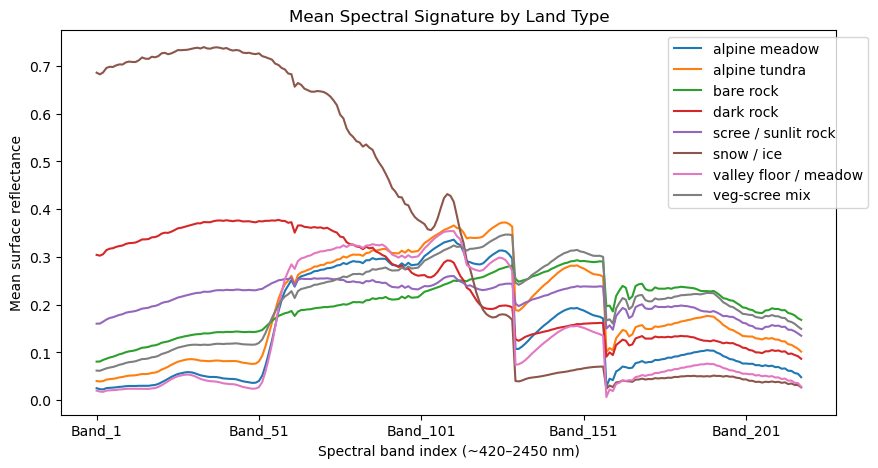

In [146]:
mean_spectra.plot(figsize=(10,5))
plt.xlabel("Spectral band index (~420–2450 nm)")
plt.ylabel("Mean surface reflectance")
plt.title("Mean Spectral Signature by Land Type")
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

Note that for Lines that differ strongly it means those classes are spectrally separable, so classification should work well. For the Overlapping lines the classes are spectrally similar, so may need nonlinear models (e.g. GBDT / SVM).
There is smoothness across bands, which confirms that adjacent bands are highly correlated. Motivates PCA or regularisation later.

Inspect the correlations across the features

In [147]:
#Correlation for the first 50 bands
corr50 = data1[bands[:50]].corr()
corr50.head()

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_41,Band_42,Band_43,Band_44,Band_45,Band_46,Band_47,Band_48,Band_49,Band_50
Band_1,1.000000,0.999913,0.999751,0.999725,0.999568,0.999415,0.999241,0.999069,0.998893,0.998669,...,0.987480,0.987046,0.986826,0.986319,0.985778,0.985245,0.984841,0.984364,0.984131,0.984004
Band_2,0.999913,1.000000,0.999900,0.999852,0.999749,0.999643,0.999507,0.999372,0.999228,0.999033,...,0.988637,0.988226,0.988020,0.987535,0.987021,0.986518,0.986121,0.985680,0.985458,0.985344
Band_3,0.999751,0.999900,1.000000,0.999895,0.999857,0.999800,0.999713,0.999626,0.999520,0.999370,...,0.989884,0.989494,0.989305,0.988850,0.988370,0.987901,0.987526,0.987124,0.986919,0.986813
Band_4,0.999725,0.999852,0.999895,1.000000,0.999946,0.999893,0.999819,0.999731,0.999636,0.999497,...,0.990457,0.990073,0.989879,0.989434,0.988956,0.988483,0.988133,0.987702,0.987495,0.987376
Band_5,0.999568,0.999749,0.999857,0.999946,1.000000,0.999958,0.999914,0.999852,0.999783,0.999673,...,0.991277,0.990907,0.990722,0.990297,0.989839,0.989387,0.989045,0.988637,0.988438,0.988324


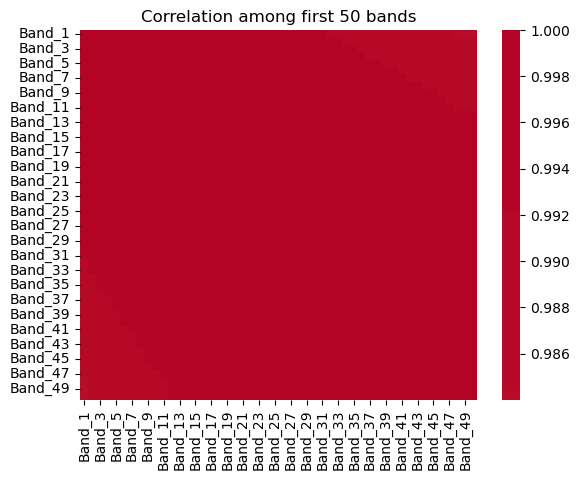

In [148]:
#Correlation heatmap for the first 50 bands
sns.heatmap(corr50, cmap="coolwarm", center=0)
plt.title("Correlation among first 50 bands")
plt.show()

In [149]:
#Correlation among all the bands
corrfull = data1[bands].corr()
corrfull

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_209,Band_210,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218
Band_1,1.000000,0.999913,0.999751,0.999725,0.999568,0.999415,0.999241,0.999069,0.998893,0.998669,...,-0.118024,-0.112026,-0.108653,-0.103823,-0.102215,-0.100490,-0.094597,-0.088633,-0.085640,-0.076818
Band_2,0.999913,1.000000,0.999900,0.999852,0.999749,0.999643,0.999507,0.999372,0.999228,0.999033,...,-0.112683,-0.106617,-0.103273,-0.098361,-0.096793,-0.095018,-0.089128,-0.083031,-0.080061,-0.071073
Band_3,0.999751,0.999900,1.000000,0.999895,0.999857,0.999800,0.999713,0.999626,0.999520,0.999370,...,-0.104604,-0.098490,-0.095150,-0.090173,-0.088617,-0.086801,-0.080892,-0.074699,-0.071755,-0.062641
Band_4,0.999725,0.999852,0.999895,1.000000,0.999946,0.999893,0.999819,0.999731,0.999636,0.999497,...,-0.105168,-0.099064,-0.095699,-0.090748,-0.089174,-0.087400,-0.081466,-0.075300,-0.072335,-0.063284
Band_5,0.999568,0.999749,0.999857,0.999946,1.000000,0.999958,0.999914,0.999852,0.999783,0.999673,...,-0.100995,-0.094867,-0.091493,-0.086508,-0.084935,-0.083146,-0.077187,-0.070987,-0.068010,-0.058924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Band_214,-0.100490,-0.095018,-0.086801,-0.087400,-0.083146,-0.080034,-0.076465,-0.072115,-0.068837,-0.065164,...,0.997632,0.998212,0.998386,0.998654,0.998687,1.000000,0.998516,0.998328,0.997761,0.996478
Band_215,-0.094597,-0.089128,-0.080892,-0.081466,-0.077187,-0.074064,-0.070480,-0.066120,-0.062836,-0.059145,...,0.997493,0.997988,0.998316,0.998611,0.998710,0.998516,1.000000,0.998478,0.998485,0.996351
Band_216,-0.088633,-0.083031,-0.074699,-0.075300,-0.070987,-0.067825,-0.064235,-0.059868,-0.056571,-0.052888,...,0.996589,0.997401,0.997556,0.998306,0.998227,0.998328,0.998478,1.000000,0.998332,0.997762
Band_217,-0.085640,-0.080061,-0.071755,-0.072335,-0.068010,-0.064843,-0.061230,-0.056865,-0.053564,-0.049870,...,0.995945,0.996650,0.997051,0.997647,0.997751,0.997761,0.998485,0.998332,1.000000,0.996819


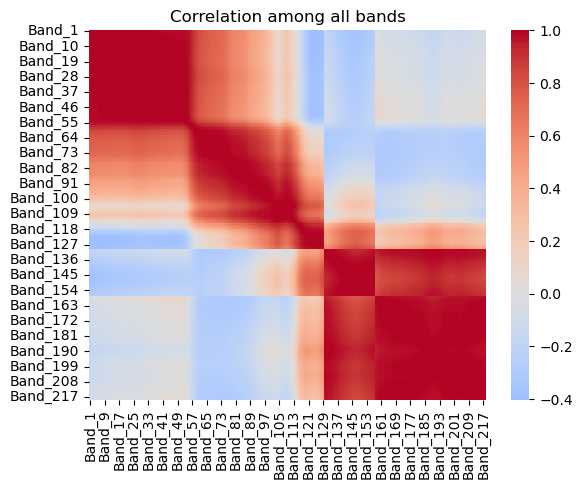

In [150]:

# Correlation heatmap for all bands
sns.heatmap(corrfull, cmap="coolwarm", center=0)
plt.title("Correlation among all bands")
plt.show()


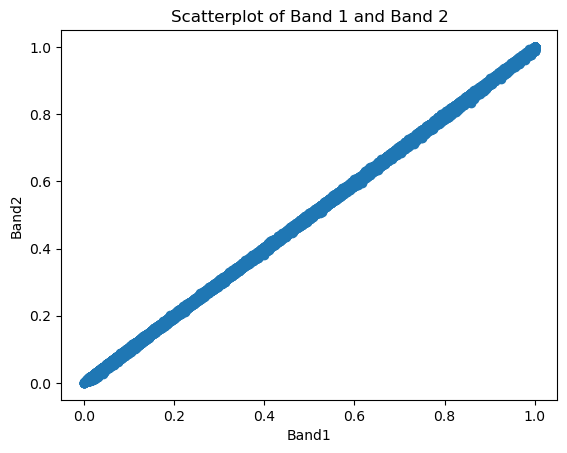

In [151]:
plt.scatter(data1["Band_1"], data1["Band_2"])
plt.xlabel("Band1")
plt.ylabel("Band2")
plt.title("Scatterplot of Band 1 and Band 2")
plt.show()

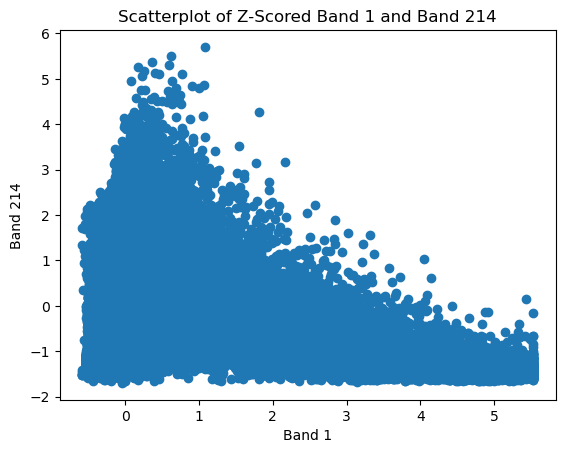

In [152]:
plt.scatter((data1["Band_1"] - data1["Band_1"].mean())/data1["Band_1"].std(), (data1["Band_214"] - data1["Band_214"].mean())/data1["Band_214"].std())
plt.xlabel("Band 1")
plt.ylabel("Band 214")
plt.title("Scatterplot of Z-Scored Band 1 and Band 214")
plt.show()

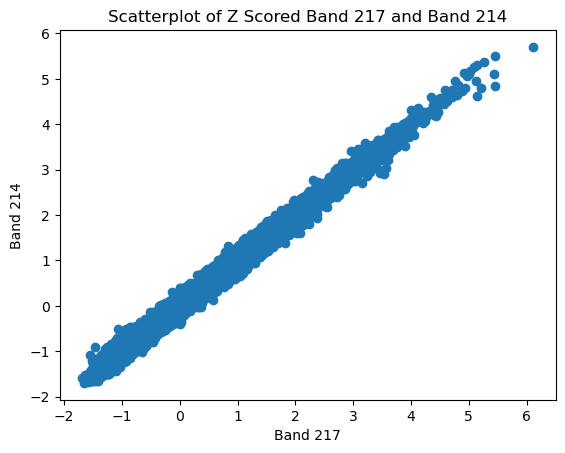

In [153]:
plt.scatter((data1["Band_217"] - data1["Band_217"].mean())/data1["Band_217"].std(), (data1["Band_214"] - data1["Band_214"].mean())/data1["Band_214"].std())
plt.xlabel("Band 217")
plt.ylabel("Band 214")
plt.title("Scatterplot of Z Scored Band 217 and Band 214")
plt.show()

We can observe that the correlation is larger among neighboring features. For example the average correlation is much larger when only the first 50 bands are considered than when all the bands are considered. Indeed, we can observe that correlation even becomes negative for some distant bands. We have defined distant bands in a very rough way, as the difference between distance labels.

We should also look at the conditional distributions of the bands to better understand the shape.

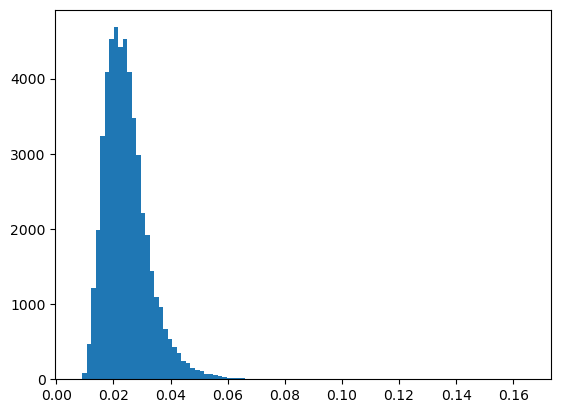

In [154]:
plt.hist(data1[data1["land_type"] == "alpine meadow"]["Band_1"], bins = 100)
plt.show()

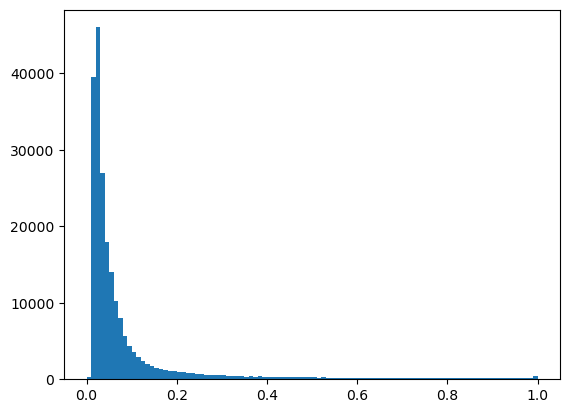

In [155]:
plt.hist(data1["Band_1"], bins = 100)
plt.show()

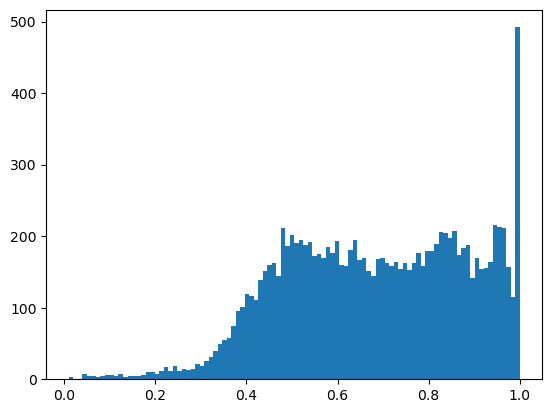

In [156]:
plt.hist(data1[data1["land_type"] == "snow / ice"]["Band_1"], bins = 100)
plt.show()

We can observe heterogeneous conditional distributions. In particular, Band 1 values are larger for the land type snow/ice, and many of the values achieve the maximumm threshold.

Before fitting the models, we will do two more tasks: Clustering and PCA. Clustering will helps us visualize the features more, and PCA will be able to help us for dimensionality reduction. Due to the large number of features, it might be helpful to do Clustering on the first principal components. We will apply PCA to the training set, and then clustering. PCA will help evaluate whether we can reduce dimensionality, while clustering will aid us in visualizing the features.

Find the bands

In [157]:
X_bands = data1[bands]

Perform PCA using 4 components

In [158]:
X_pca = StandardScaler().fit_transform(X_bands)
pca  = PCA(n_components=4).fit(X_bands)
print(f"\n Percentage of Variance explained by the first four principal components: {np.round(sum(pca.explained_variance_ratio_) * 100, 3)} %")


 Percentage of Variance explained by the first four principal components: 99.787 %


Percentage of explained Variance by each component

In [159]:
principal_components = pd.DataFrame({"Component": [1, 2, 3, 4], "Percentage of Explained Variance": np.round(pca.explained_variance_ratio_ * 100, 3)}).set_index("Component")
principal_components

,Percentage of Explained Variance
Component,
1,68.618
2,16.688
3,14.236
4,0.245


PCA singular values

In [160]:
singular_values = pd.DataFrame({"Component": [1, 2, 3, 4], "Singular Value": pca.singular_values_}).set_index("Component")
singular_values

,Singular Value
Component,
1,637.031692
2,314.156186
3,290.157963
4,38.027277


PCA eigenvectors

In [161]:
eigenvectors = pd.DataFrame(pca.components_)
eigenvectors

,0,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,215,216,217
0,0.117656,0.117390,0.118208,0.119438,0.119848,0.119719,0.120195,0.120326,0.120226,0.120818,...,-0.005965,-0.005776,-0.005645,-0.005467,-0.005400,-0.005277,-0.004974,-0.004759,-0.004487,-0.004246
1,-0.004128,-0.002890,-0.001154,-0.001242,-0.000336,0.000337,0.001118,0.002148,0.002878,0.003728,...,0.083193,0.083311,0.082821,0.082844,0.081894,0.080270,0.079044,0.079353,0.076018,0.077103
2,-0.035873,-0.036372,-0.037730,-0.037920,-0.038676,-0.039061,-0.039670,-0.040043,-0.040382,-0.040962,...,-0.024634,-0.025732,-0.026190,-0.026912,-0.027327,-0.027615,-0.027686,-0.028423,-0.027869,-0.029420
3,-0.105355,-0.098306,-0.092024,-0.089810,-0.084713,-0.080395,-0.077146,-0.074986,-0.072527,-0.070333,...,0.042931,0.044996,0.045198,0.047601,0.048634,0.049223,0.051503,0.055334,0.055171,0.059374


We can observe that only the first three principal components capture 99% of the variance in the feature space, so we can retain only the frist 3 principal components. This suggests that dimensionality reduction is achievable on this dataset.

In [162]:
Z = PCA(n_components=3).fit_transform(X_pca)

We will now perform clustering on the reduced dataset using K-Means. It is better to apply K-Means on the PCA transformed dataset for stability. For visualization purposes, we will perform clustering on the first two principal components only.


In [163]:
pc1 = Z[:, 0]
pc2 = Z[:, 1]
kmeans = KMeans(n_clusters=3)
cluster = kmeans.fit_predict(Z[:, 0:2])

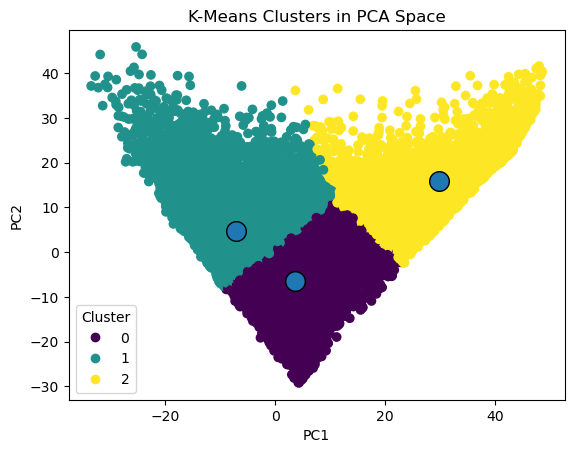

In [164]:
scatter = plt.scatter(pc1, pc2, c = cluster)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],
            marker="o", s=200, edgecolor="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters in PCA Space")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


The K-Means does not aid us too much in visualizing the features when we use the first 2 PCs. Clusters seem arbitrarily separated, and, indeed, the scatteplot does not suggest clustering in the PCA space. As such, we will only use PCA for dimensionality reduction and model fitting.

## Task 1.2 - Model Development

In this part of the project, we will try to predict the Vegetation type based on the reflectance values of the pixels. This is a MultiClass classification problem, and we will use several types of classifiers for this task. To encode the variables from categorical to numerical, we will use Scikit Learn's Label Encoder. The methodology will be the following: we will fit the models and report the cross-validation errors on the training set to adjust the hyperparamters. After finding the best model, we will fit it to the whole training data, and report its performance on the test set. The test set will be used only to report the performance.

### Define functions to evaluate performances

Create function to report cross-validation performance - This will help us tweak the hyperparameters in case it's necessary.

In [165]:
def evaluate_cv(estimator, X, y, scoring_list, model_name = "model"):
    
    #Define StratifiedKFold splitter. This makes sure than no split is more imbalanced than the original data
    cv_splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    #Calculate the CV score for each metric
    cv_results = cross_validate(
        estimator, 
        X, 
        y, 
        scoring = scoring_list, 
        cv = cv_splitter, 
        return_train_score=False
    )

    #Create a dataframe with all the performance metrics using cv
    row = {"model": model_name}
    for k, v in cv_results.items():
        if k.startswith("test_"):
            metric = k.replace("test_", "")
            row[f"{metric}"] = np.mean(v)
        
    return pd.DataFrame([row]).set_index("model")

Function to evaluate the performance on the test set, and return the predictions

In [166]:
def predict_evaluate(estimator, X_tr: pd.DataFrame, X_ts: pd.DataFrame, y_tr: pd.DataFrame, y_ts, model_name: str):

    #Fit the estimator on the training data
    classifier = estimator.fit(X_tr, y_tr)

    #Find the predictions and probabilities
    predictions = classifier.predict(X_ts)
    predictions_prob = classifier.predict_proba(X_ts)

    #Calculate the error metrics using predictions
    acc = accuracy_score(y_ts, predictions)
    balanced_acc = balanced_accuracy_score(y_ts, predictions)
    f1 = f1_score(y_ts, predictions, average="macro")

    #Calculate auroc using the probabilities
    auc = roc_auc_score(y_ts, predictions_prob, average = "macro", multi_class="ovr")

    return pd.DataFrame({"model": [model_name], "Accuracy": [acc], "Bal. Acc": [balanced_acc], "AUC": [auc], "F1": [f1]}), predictions


Generalization of the previous function to test the performance of multiple models

In [167]:
def multiple_predict_evaluate(models:list[tuple], X_tr: pd.DataFrame, X_ts: pd.DataFrame, y_tr, y_ts):

    #Create a list of dataframes to hold the performances of each model
    metrics_list = []

    #Create a list of dataframes to hold the predictions from each model
    predictions_list = []

    #Iterate through each model
    for model, estimator in models:
        
        #report the performance and predicitions of the model
        metric, preds = predict_evaluate(estimator, X_tr, X_ts, y_tr, y_ts, model)

        #Append the performance to the metrics list
        metrics_list.append(metric)

        #Create dataframe to hold the predictions
        df_model = pd.DataFrame({f"{model}": preds})

        #Append the dataframe to the  predictions_list
        predictions_list.append(df_model)

    #Return the concatenated dataframes
    return pd.concat(metrics_list, ignore_index = True), pd.concat(predictions_list, axis = 1)

Function to plot the confusion matrix

In [168]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize, model_name):

    #Create figure
    fig = plt.figure(figsize=(12, 12), dpi=100)  # FORCE a large, readable figure
    ax = fig.add_subplot(111)

    #Create Confusion Matrix display
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=class_names,
        normalize=normalize,
        cmap="Blues",
        colorbar=True,
        ax=ax
    )
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.title(f"Confusion Matrix - {model_name}", fontsize=20)
    plt.tight_layout()
    plt.show()

### Preparations of the features and the target

Find the features and the target

In [169]:
features = data1.drop(columns=["land_type","rgb_hex", "overlay_hex"])
target  = data1["land_type"]

Split into a training set and a test set

In [170]:
# General train/test split, for models\svm, knn
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True,
    stratify=target #This ensures the train and test set follow the same distribution as the original dataset
)

In [171]:
features_1 = data1_1.drop(columns=["land_type","rgb_hex", "overlay_hex"])
target_1  = data1_1["land_type"]

In [172]:
# Sample train/test split for svm, knn
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    features_1, 
    target_1, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True,
    stratify=target_1 #This ensures the train and test set follow the same distribution as the original dataset
)

In [173]:
print(f"\n Number of observations in the training set: {X_train.shape[0]}", f"\n Number of observations in the test set: {X_test.shape[0]}")

print(f"\n Number of observations in the training set (sampled data): {X_train_1.shape[0]}", f"\n Number of observations in the test set: {X_test_1.shape[0]}")


 Number of observations in the training set: 172483 
 Number of observations in the test set: 43121

 Number of observations in the training set (sampled data): 24000 
 Number of observations in the test set: 6000


In [174]:
X_train.head()

,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,...,Band_209,Band_210,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218
144660,175,407,0.0207,0.0199,0.0179,0.0213,0.0215,0.0214,0.0223,0.0235,...,0.0613,0.0571,0.0608,0.0524,0.0563,0.0493,0.0491,0.0418,0.0428,0.0361
55929,194,157,0.1371,0.1397,0.1428,0.1476,0.1535,0.1550,0.1593,0.1606,...,0.1836,0.1824,0.1843,0.1797,0.1814,0.1710,0.1746,0.1740,0.1678,0.1603
145433,238,409,0.0205,0.0173,0.0178,0.0223,0.0221,0.0224,0.0229,0.0244,...,0.0947,0.0945,0.0916,0.0887,0.0900,0.0855,0.0839,0.0806,0.0727,0.0747
49983,283,140,0.0450,0.0395,0.0394,0.0440,0.0435,0.0447,0.0452,0.0472,...,0.1416,0.1365,0.1323,0.1247,0.1293,0.1247,0.1114,0.1015,0.0980,0.0854
144191,61,406,0.0372,0.0332,0.0318,0.0369,0.0354,0.0351,0.0370,0.0359,...,0.0764,0.0687,0.0755,0.0644,0.0708,0.0623,0.0712,0.0549,0.0559,0.0455


In [175]:
y_train.head()

144660          alpine meadow
55929     scree / sunlit rock
145433          alpine tundra
49983           alpine meadow
144191          alpine meadow
Name: land_type, dtype: object

Check wehether there is any overlap between the training set and the test set

In [176]:
assert set(X_train.index).isdisjoint(set(X_test.index))
assert set(X_train_1.index).isdisjoint(set(X_test_1.index))

No overlap between the training set and the test set.

Use LabelEncoder to transform categorical targets into integer targets

In [177]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [178]:
le_1 = LabelEncoder()
y_train_encoded_1 = le_1.fit_transform(y_train_1)
y_test_encoded_1 = le_1.transform(y_test_1)

Training target

In [179]:
y_train_encoded

array([0, 4, 1, ..., 0, 2, 0])

In [180]:
y_train_encoded_1

array([0, 2, 6, ..., 1, 2, 2])

Test target

In [181]:
y_test_encoded

array([6, 1, 1, ..., 0, 5, 6])

In [182]:
y_test_encoded_1

array([6, 1, 0, ..., 1, 0, 0])

Classes as integers

In [183]:
np.unique(y_train_encoded)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [184]:
np.unique(y_train_encoded_1)

array([0, 1, 2, 3, 4, 5, 6, 7])

### Create pipelines to fit the models. One pipeline will fit on the raw data, and the other one will fit on the data after PCA with 10 components is applied for each model considered.

In [185]:
pipe_logistic = Pipeline(
    [("scaler", StandardScaler()),
     ("logit_classifier", LogisticRegression(
         solver= "lbfgs", 
         max_iter=2000                 # increase to avoid convergence warning
     ))
    ]
)

pipe_logistic_pca = Pipeline(
    [("scaler", StandardScaler()),
     ("pca", PCA(n_components=10)),
     ("logistic_classifier", LogisticRegression(
         solver = "lbfgs", #saga is fater for larger datasets
         max_iter=2000                 # increase to avoid convergence warning
     ))
    ]
)

# Define LDA pipelines: one raw (full data), one with PCA10
lda_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearDiscriminantAnalysis())
])

lda_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),
    ("clf", LinearDiscriminantAnalysis())
])


# Define QDA pipelines: one raw (full data), one with PCA10
qda_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", QuadraticDiscriminantAnalysis(reg_param=0.01))
])

qda_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),
    ("clf", QuadraticDiscriminantAnalysis(reg_param=0.01))
])

# Define Random Forest pipelines: one raw (full data), one with PCA10
rf_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        criterion='gini',
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        max_features='sqrt'))
])

rf_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),
    ("clf", RandomForestClassifier(
        criterion='gini',
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        max_features='sqrt'))
])

# Define GBDT pipelines: one raw (full data), one with PCA10
gbdt_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.15,
        max_depth=2,
        subsample=0.7,
        max_features="sqrt",
        random_state=42))
])

gbdt_pca10 = Pipeline([
    ("scaler", StandardScaler()),
     ("pca", PCA(n_components=10, random_state=42)),
    ("clf", GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.15,
        max_depth=2,
        subsample=0.7,
        max_features="sqrt",
        random_state=42))
])

# ==============
# KNN pipelines
# ==============

knn_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(
        n_neighbors=7,
        weights="distance"
    ))
])

knn_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),
    ("clf", KNeighborsClassifier(
        n_neighbors=7,
        weights="distance"
    ))
])

# ==============
# SVM pipelines
# ==============

svm_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        C=20,
        gamma="scale",
        probability=True
    ))
])

svm_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),
    ("clf", SVC(
        kernel="rbf",
        C=20,
        gamma="scale",
        probability=True
    ))
])


### Cross Validation performance on the training set

Create a list of metrics that we will use for evaluation

In [186]:
scoring_list = {"Accuracy": "accuracy", "Bal. Acc": "balanced_accuracy", "AUC": "roc_auc_ovr", "F1":"f1_macro"}
#Macro means that we are taking the average over the number of classes - sensitive to class imbalance.
#ovr means that we treat one class as positive, the rest as negative for all the classes

Corss validation performance of logit

In [187]:
logit_cv = evaluate_cv(pipe_logistic, X_train, y_train_encoded, scoring_list=scoring_list, model_name="Logistic")

In [188]:
logit_cv

,Accuracy,Bal. Acc,AUC,F1
model,,,,
Logistic,0.991628,0.989853,0.99994,0.989933


Cross validation performance of LDA

In [189]:
lda_cv_raw = evaluate_cv(lda_raw, X_train, y_train, scoring_list=scoring_list, model_name="LDA Raw")

In [190]:
lda_cv_raw

,Accuracy,Bal. Acc,AUC,F1
model,,,,
LDA Raw,0.862021,0.859184,0.990746,0.860786


Cross validation performance of QDA

In [191]:
qda_cv_raw = evaluate_cv(qda_raw, X_train, y_train, scoring_list=scoring_list, model_name="QDA Raw")

In [192]:
qda_cv_raw

,Accuracy,Bal. Acc,AUC,F1
model,,,,
QDA Raw,0.920201,0.915668,0.995359,0.916021


Cross validation performance of Random Forest 

In [193]:
rf_cv_raw = evaluate_cv(rf_raw, X_train, y_train, scoring_list=scoring_list, model_name="RF Raw")

In [194]:
rf_cv_raw

,Accuracy,Bal. Acc,AUC,F1
model,,,,
RF Raw,0.983413,0.981491,0.999849,0.981658


Cross validation performance of GBDT

In [195]:
gbdt_cv_raw = evaluate_cv(gbdt_raw, X_train, y_train, scoring_list=scoring_list, model_name="GBDT Raw")

In [196]:
gbdt_cv_raw

,Accuracy,Bal. Acc,AUC,F1
model,,,,
GBDT Raw,0.944824,0.949489,0.998264,0.950215


In [236]:
knn_cv_raw=evaluate_cv(knn_raw, X_train_1, y_train_1, scoring_list=scoring_list, model_name="KNN RAW")

In [237]:
knn_cv_raw

,Accuracy,Bal. Acc,AUC,F1
model,,,,
KNN RAW,0.956583,0.956108,0.998414,0.957323


In [238]:
svm_cv_raw=evaluate_cv(svm_raw, X_train_1, y_train_1, scoring_list=scoring_list, model_name="SVM RAW")

In [239]:
svm_cv_raw

,Accuracy,Bal. Acc,AUC,F1
model,,,,
SVM RAW,0.988125,0.987338,0.999926,0.987515


### Final performance of each model on the test set

Create a list of models to test

In [240]:
#Create list of models and model names
models_list_raw = [("Logistic", pipe_logistic), 
                   ("LDA", lda_raw),
                   ("QDA", qda_raw),
                   ("RF", rf_raw),
                   ("GBDT", gbdt_raw)]

models_list_pca = [("Logistic_PCA10", pipe_logistic_pca),
                   ("LDA_PCA10", lda_pca10),
                   ("QDA_PCA10", qda_pca10),
                   ("RF_PCA10", rf_pca10),
                   ("GBDT_PCA10", gbdt_pca10)]

#--------------------------------------------->>
# USING THE SAMPLED DATA
#--------------------------------------------->>

models_list_raw_1 = [
    ("KNN", knn_raw),
    ("SVM", svm_raw)
]

models_list_pca_1 = [
    ("KNN_PCA10", knn_pca10),
    ("SVM_PCA10", svm_pca10)
]


Find the performance and predictions of each model on the test set.

In [241]:
#Find the predictions and the performance of each model, both the raw and the PCA
df_performances_raw, df_predictions_raw = multiple_predict_evaluate(models_list_raw, X_train, X_test, y_train_encoded, y_test_encoded)
df_performances_pca, df_predictions_pca = multiple_predict_evaluate(models_list_pca, X_train, X_test, y_train_encoded, y_test_encoded)

Performances of each model on the test set.

In [242]:
# SEPARATELY FOR KNN AND SVM USING THE SUBSAMPLED DATA

# Find the predictions and the performance of each model, both the raw and the PCA
df_performances_raw_1, df_predictions_raw_1 = multiple_predict_evaluate(models_list_raw_1, X_train_1, X_test_1, y_train_encoded_1, y_test_encoded_1)
df_performances_pca_1, df_predictions_pca_1 = multiple_predict_evaluate(models_list_pca_1, X_train_1, X_test_1, y_train_encoded_1, y_test_encoded_1)

In [243]:
df_performances_raw = df_performances_raw.set_index("model")
df_performances_raw

,Accuracy,Bal. Acc,AUC,F1
model,,,,
Logistic,0.992208,0.991074,0.999953,0.991160
LDA,0.861344,0.859842,0.990798,0.861787
QDA,0.921709,0.918314,0.995580,0.918858
RF,0.984949,0.983175,0.999869,0.983528
GBDT,0.947450,0.952124,0.998418,0.953050


In [244]:
# SEPARATELY FOR KNN AND SVM USING THE SUBSAMPLED DATA
df_performances_raw_1= df_performances_raw_1.set_index("model")
df_performances_raw_1

,Accuracy,Bal. Acc,AUC,F1
model,,,,
KNN,0.958833,0.954838,0.998898,0.956513
SVM,0.989667,0.988886,0.999955,0.989039


In [245]:
df_performances_pca = df_performances_pca.set_index("model")
df_performances_pca

,Accuracy,Bal. Acc,AUC,F1
model,,,,
Logistic_PCA10,0.991559,0.992349,0.999943,0.992484
LDA_PCA10,0.840588,0.833129,0.988526,0.838366
QDA_PCA10,0.931101,0.928434,0.996366,0.927886
RF_PCA10,0.976438,0.972857,0.999657,0.973879
GBDT_PCA10,0.953387,0.945051,0.998280,0.946378


In [246]:
# SEPARATELY FOR KNN AND SVM USING THE SUBSAMPLED DATA
df_performances_pca_1 = df_performances_pca_1.set_index("model")
df_performances_pca_1

,Accuracy,Bal. Acc,AUC,F1
model,,,,
KNN_PCA10,0.960000,0.95713,0.998721,0.958676
SVM_PCA10,0.988667,0.98851,0.999933,0.988755


Combined test performance for easy reading

In [247]:
df_all_raw = pd.concat([df_performances_raw, df_performances_raw_1], axis=0)
df_all_raw

,Accuracy,Bal. Acc,AUC,F1
model,,,,
Logistic,0.992208,0.991074,0.999953,0.991160
LDA,0.861344,0.859842,0.990798,0.861787
QDA,0.921709,0.918314,0.995580,0.918858
RF,0.984949,0.983175,0.999869,0.983528
GBDT,0.947450,0.952124,0.998418,0.953050
KNN,0.958833,0.954838,0.998898,0.956513
SVM,0.989667,0.988886,0.999955,0.989039


In [248]:
df_all_pca = pd.concat([df_performances_pca, df_performances_pca_1], axis=0)
df_all_pca

,Accuracy,Bal. Acc,AUC,F1
model,,,,
Logistic_PCA10,0.991559,0.992349,0.999943,0.992484
LDA_PCA10,0.840588,0.833129,0.988526,0.838366
QDA_PCA10,0.931101,0.928434,0.996366,0.927886
RF_PCA10,0.976438,0.972857,0.999657,0.973879
GBDT_PCA10,0.953387,0.945051,0.998280,0.946378
KNN_PCA10,0.960000,0.957130,0.998721,0.958676
SVM_PCA10,0.988667,0.988510,0.999933,0.988755


Predictions of each model on the test set.

In [249]:
df_predictions_raw

,Logistic,LDA,QDA,RF,GBDT
0,6,6,6,6,6
1,1,0,1,1,1
2,1,7,1,1,1
3,2,4,2,2,2
4,5,5,5,5,5
...,...,...,...,...,...
43116,0,0,0,0,0
43117,0,0,6,0,0
43118,0,6,0,0,0
43119,5,5,5,5,5


In [250]:
df_predictions_raw_1

,KNN,SVM
0,6,6
1,1,1
2,0,0
3,6,6
4,6,6
...,...,...
5995,3,3
5996,2,2
5997,1,1
5998,0,0


In [251]:
df_predictions_pca

,Logistic_PCA10,LDA_PCA10,QDA_PCA10,RF_PCA10,GBDT_PCA10
0,6,6,6,6,6
1,1,1,1,1,1
2,1,1,1,1,1
3,2,4,2,2,2
4,5,5,5,5,5
...,...,...,...,...,...
43116,0,0,0,0,0
43117,0,0,6,0,0
43118,0,6,0,0,0
43119,5,3,5,5,5


In [252]:
df_predictions_pca_1

,KNN_PCA10,SVM_PCA10
0,6,6
1,1,1
2,0,0
3,6,6
4,6,6
...,...,...
5995,3,3
5996,2,2
5997,1,1
5998,0,0


Predictions mapped to original land_types.

In [253]:
df_pred_original_raw = df_predictions_raw.apply(le.inverse_transform)
df_pred_original_raw

,Logistic,LDA,QDA,RF,GBDT
0,valley floor / meadow,valley floor / meadow,valley floor / meadow,valley floor / meadow,valley floor / meadow
1,alpine tundra,alpine meadow,alpine tundra,alpine tundra,alpine tundra
2,alpine tundra,veg-scree mix,alpine tundra,alpine tundra,alpine tundra
3,bare rock,scree / sunlit rock,bare rock,bare rock,bare rock
4,snow / ice,snow / ice,snow / ice,snow / ice,snow / ice
...,...,...,...,...,...
43116,alpine meadow,alpine meadow,alpine meadow,alpine meadow,alpine meadow
43117,alpine meadow,alpine meadow,valley floor / meadow,alpine meadow,alpine meadow
43118,alpine meadow,valley floor / meadow,alpine meadow,alpine meadow,alpine meadow
43119,snow / ice,snow / ice,snow / ice,snow / ice,snow / ice


In [254]:
# SEPARATELY FOR KNN AND SVM USING THE SUBSAMPLED DATA
df_pred_original_raw_1 = df_predictions_raw_1.apply(le_1.inverse_transform)
df_pred_original_raw_1

,KNN,SVM
0,valley floor / meadow,valley floor / meadow
1,alpine tundra,alpine tundra
2,alpine meadow,alpine meadow
3,valley floor / meadow,valley floor / meadow
4,valley floor / meadow,valley floor / meadow
...,...,...
5995,dark rock,dark rock
5996,bare rock,bare rock
5997,alpine tundra,alpine tundra
5998,alpine meadow,alpine meadow


In [255]:
df_pred_original_pca = df_predictions_pca.apply(le.inverse_transform)
df_pred_original_pca

,Logistic_PCA10,LDA_PCA10,QDA_PCA10,RF_PCA10,GBDT_PCA10
0,valley floor / meadow,valley floor / meadow,valley floor / meadow,valley floor / meadow,valley floor / meadow
1,alpine tundra,alpine tundra,alpine tundra,alpine tundra,alpine tundra
2,alpine tundra,alpine tundra,alpine tundra,alpine tundra,alpine tundra
3,bare rock,scree / sunlit rock,bare rock,bare rock,bare rock
4,snow / ice,snow / ice,snow / ice,snow / ice,snow / ice
...,...,...,...,...,...
43116,alpine meadow,alpine meadow,alpine meadow,alpine meadow,alpine meadow
43117,alpine meadow,alpine meadow,valley floor / meadow,alpine meadow,alpine meadow
43118,alpine meadow,valley floor / meadow,alpine meadow,alpine meadow,alpine meadow
43119,snow / ice,dark rock,snow / ice,snow / ice,snow / ice


In [256]:
# SEPARATELY FOR KNN AND SVM USING THE SUBSAMPLED DATA
df_pred_original_pca_1 = df_predictions_pca_1.apply(le_1.inverse_transform)
df_pred_original_pca_1

,KNN_PCA10,SVM_PCA10
0,valley floor / meadow,valley floor / meadow
1,alpine tundra,alpine tundra
2,alpine meadow,alpine meadow
3,valley floor / meadow,valley floor / meadow
4,valley floor / meadow,valley floor / meadow
...,...,...
5995,dark rock,dark rock
5996,bare rock,bare rock
5997,alpine tundra,alpine tundra
5998,alpine meadow,alpine meadow


### Confusion matrices

Confusion matrix for Logitstic.

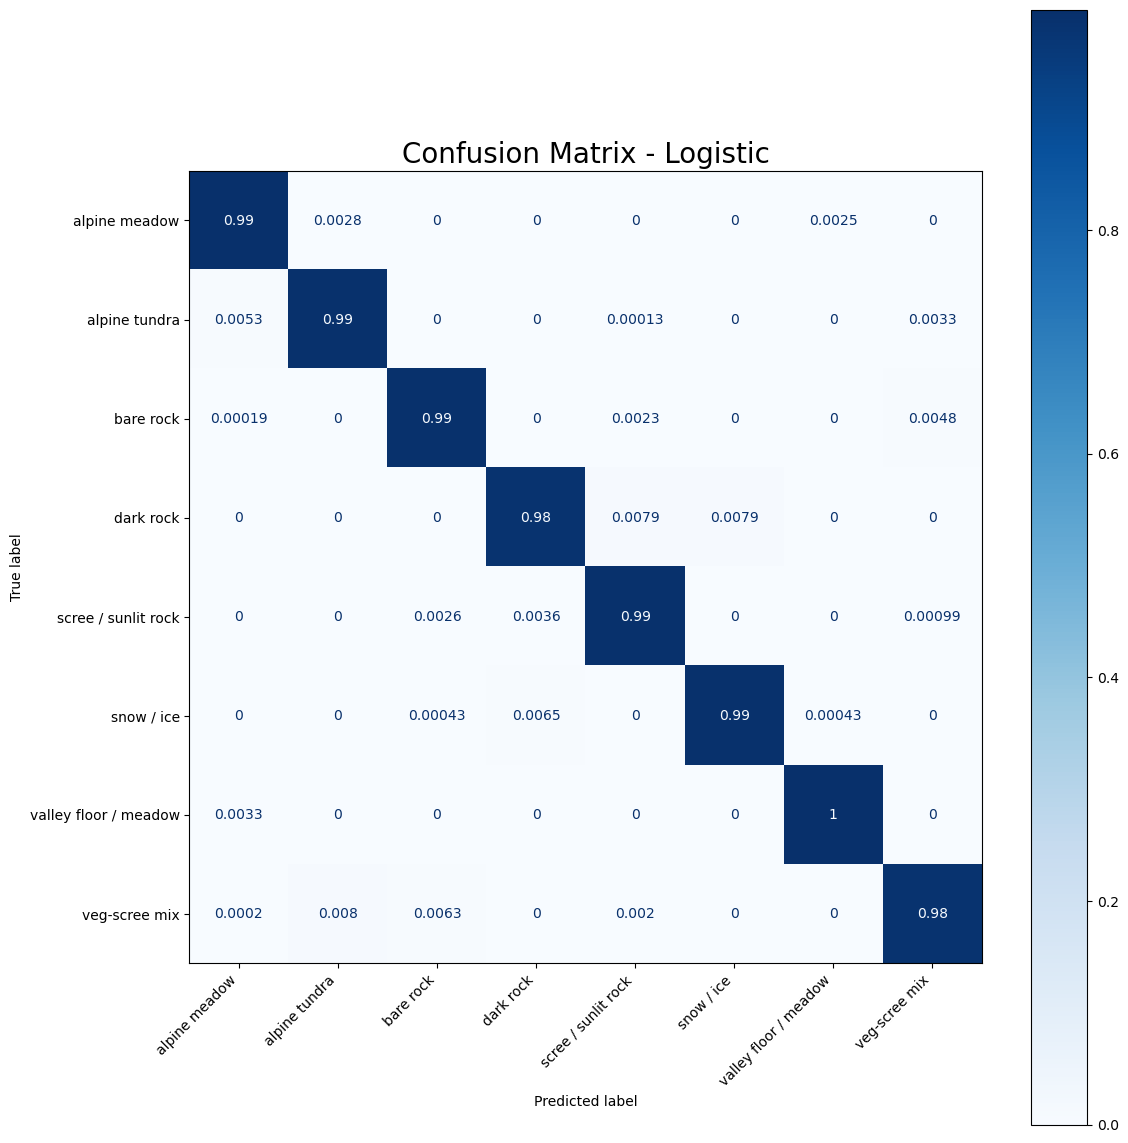

In [257]:
#Raw logistic confusion matrix
plot_confusion_matrix(y_test_encoded, df_predictions_raw["Logistic"], le.classes_, "true", "Logistic")

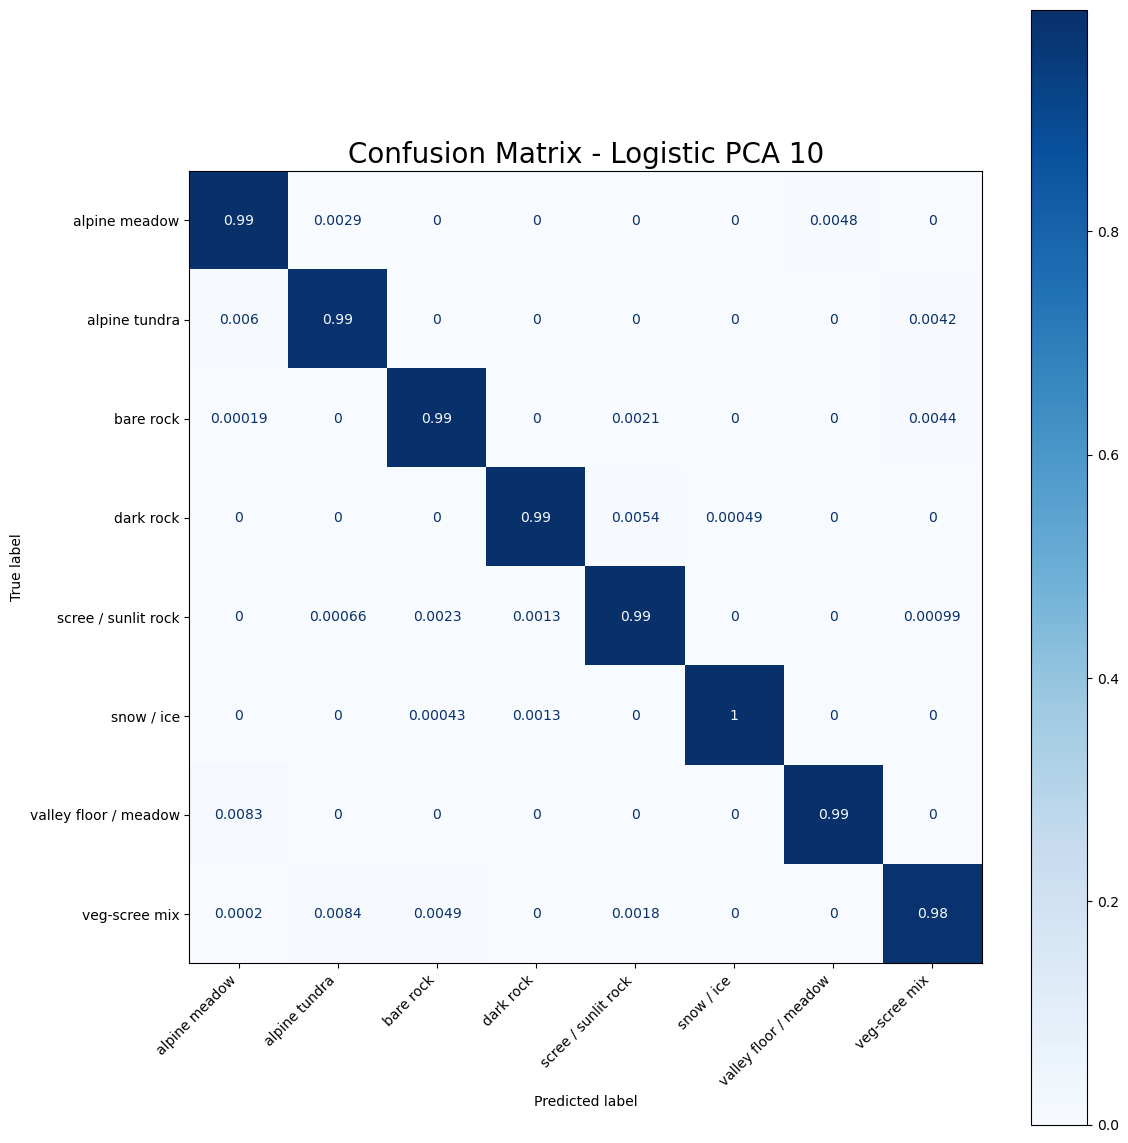

In [258]:
#PCA logistic confusion matrix
plot_confusion_matrix(y_test_encoded, df_predictions_pca["Logistic_PCA10"], le.classes_, "true", "Logistic PCA 10")

Confusion matrix for LDA.

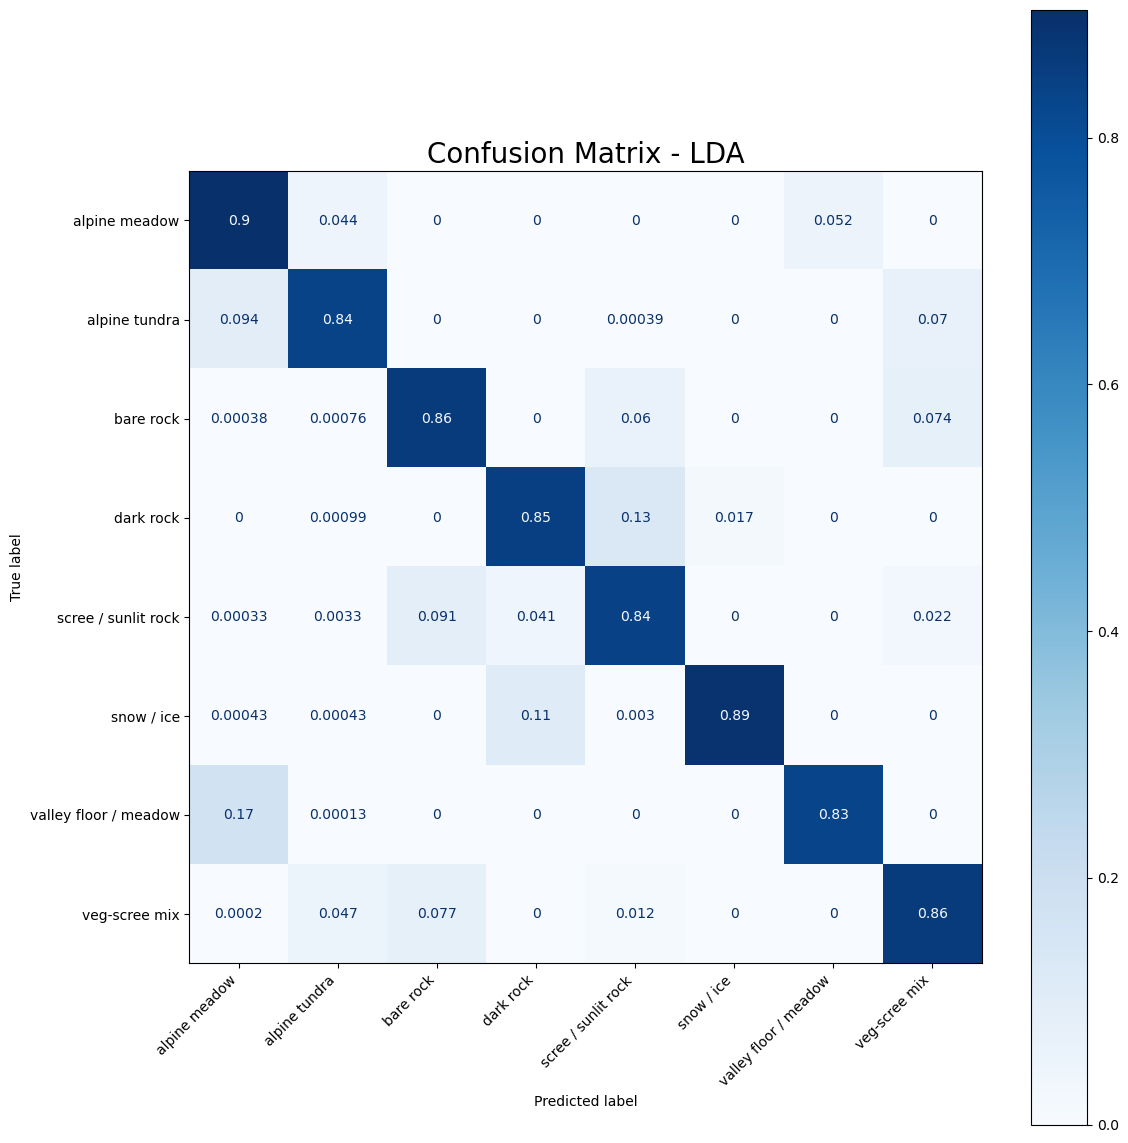

In [259]:
plot_confusion_matrix(y_test_encoded, df_predictions_raw["LDA"], le.classes_, "true", "LDA")

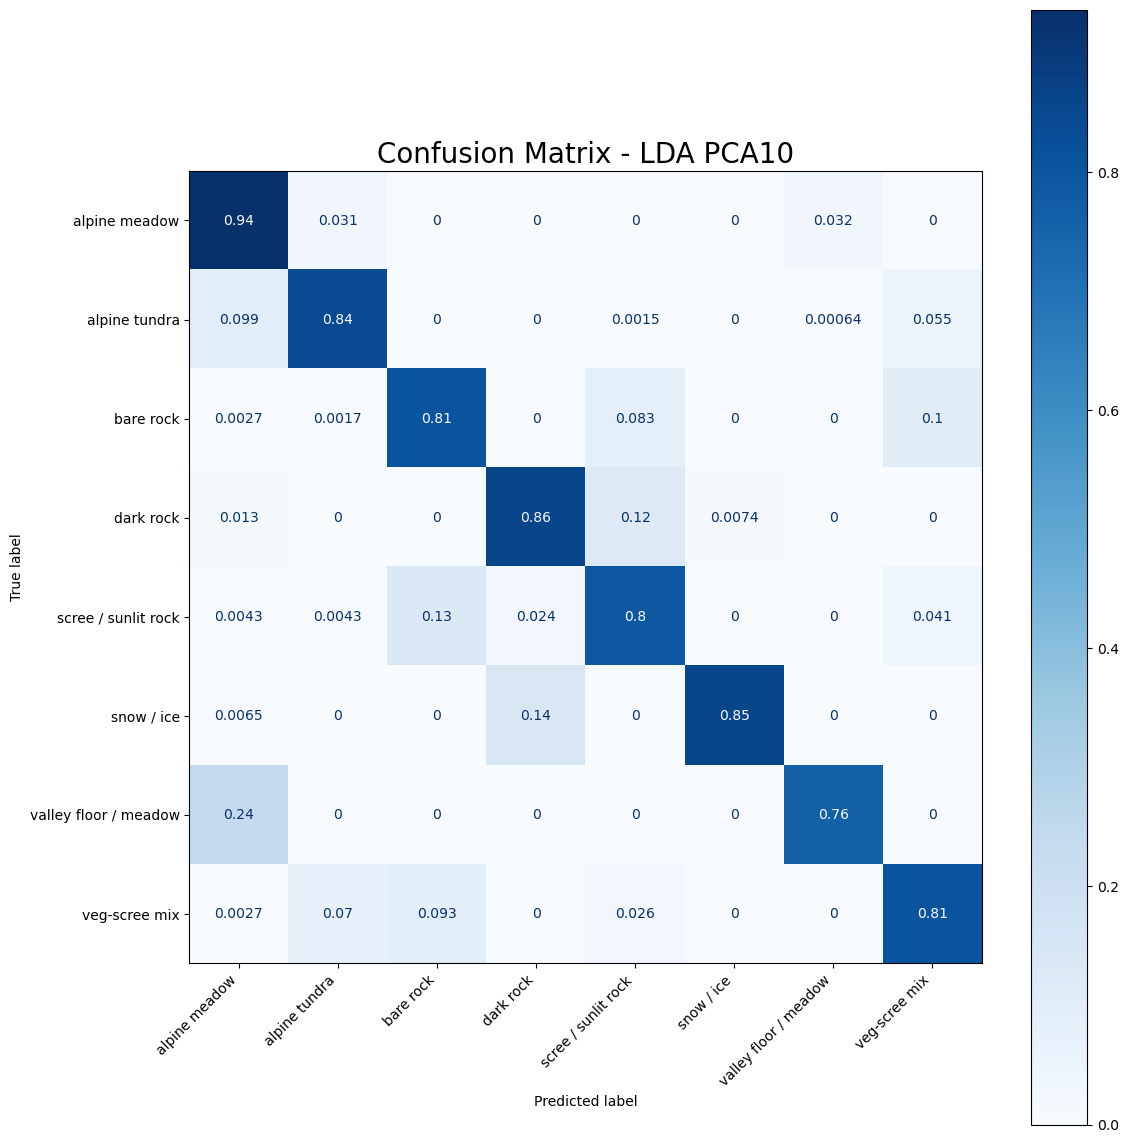

In [260]:
plot_confusion_matrix(y_test_encoded, df_predictions_pca["LDA_PCA10"], le.classes_, "true", "LDA PCA10")

Confusion matrix for QDA.

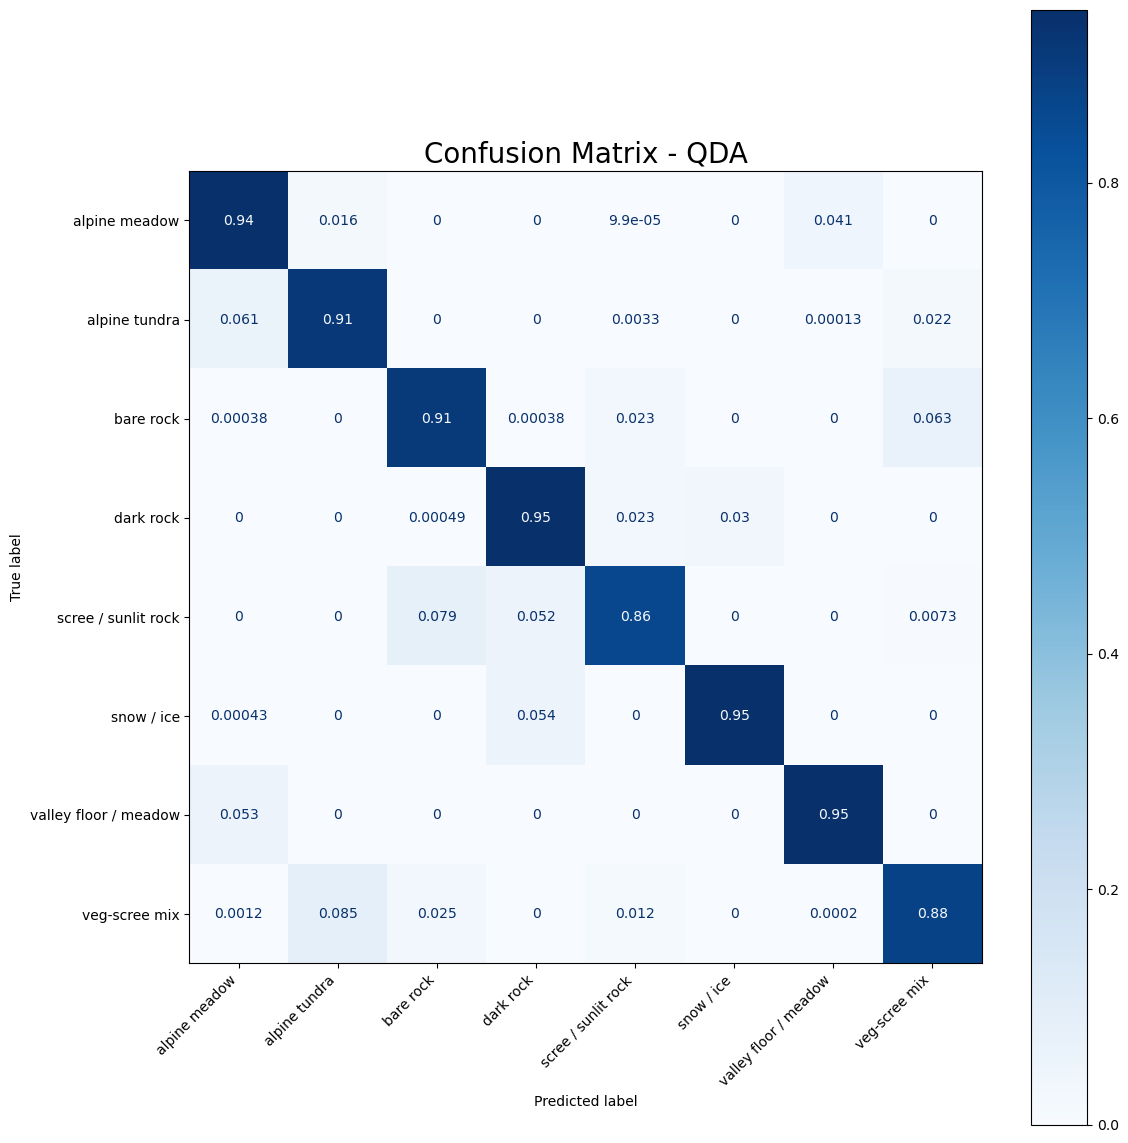

In [261]:
plot_confusion_matrix(y_test_encoded, df_predictions_raw["QDA"], le.classes_, "true", "QDA")

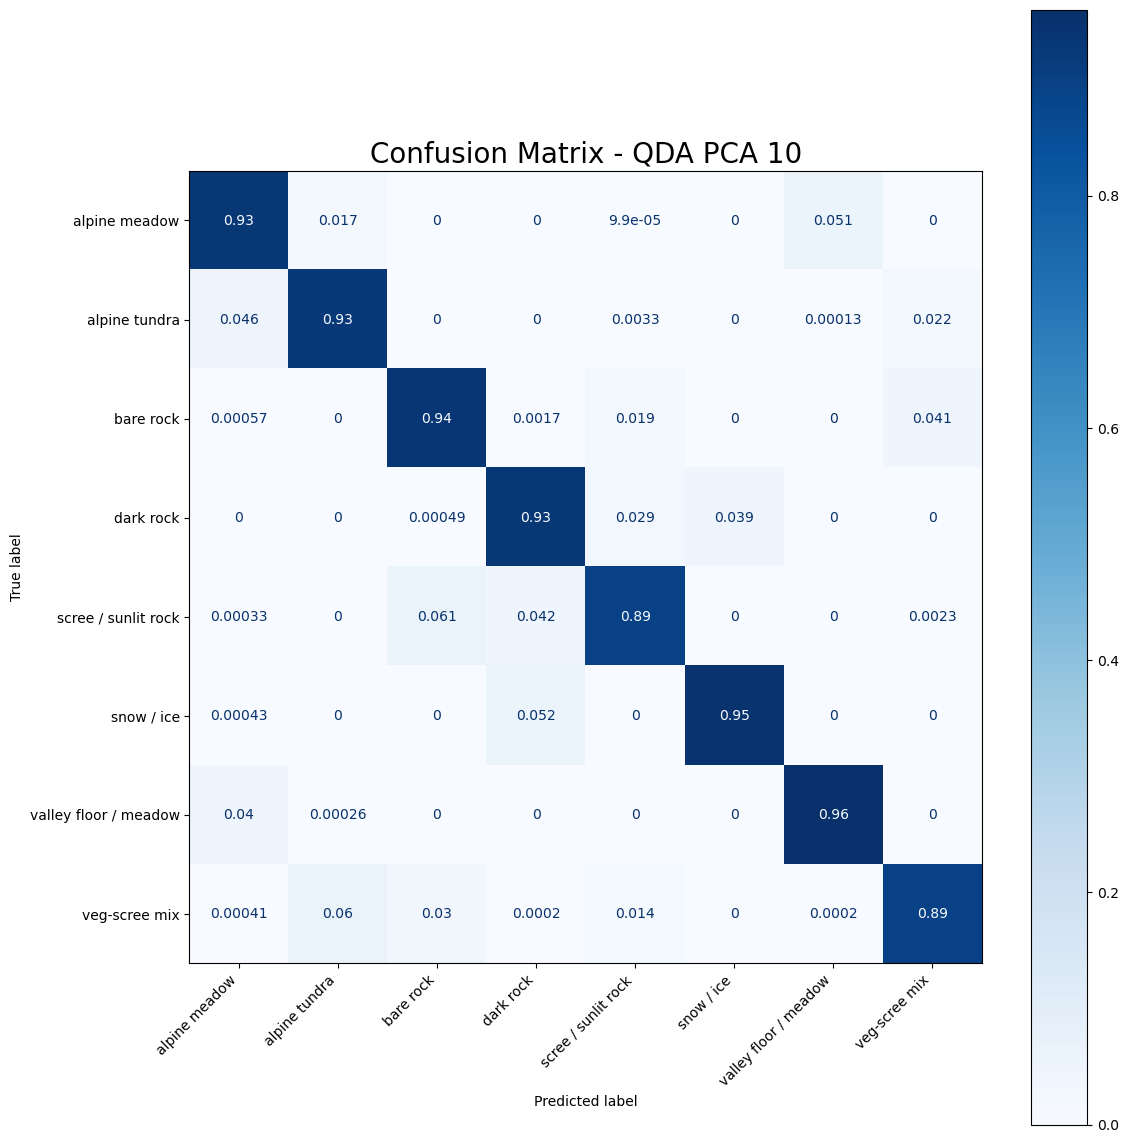

In [262]:
plot_confusion_matrix(y_test_encoded, df_predictions_pca["QDA_PCA10"], le.classes_, "true", "QDA PCA 10")

QDA does improved the modelling a bit from LDA but not enough to boost our prediction confidence. Some more complex models may work.

Confusion Matrix for Random Forest.

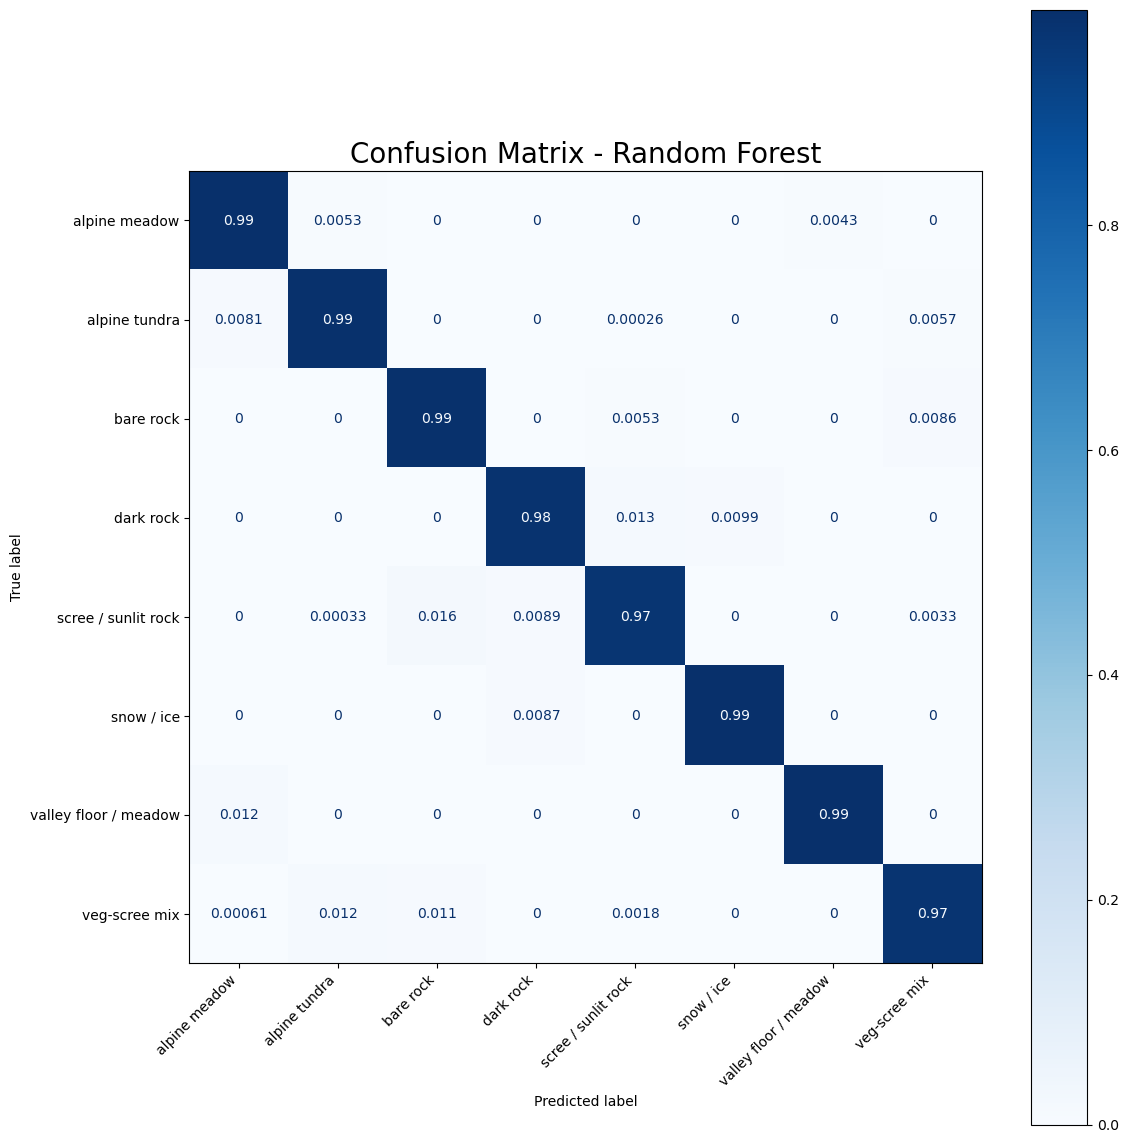

In [263]:
#Raw Random Forest confusion matrix
plot_confusion_matrix(y_test_encoded, df_predictions_raw["RF"], le.classes_, "true", "Random Forest")

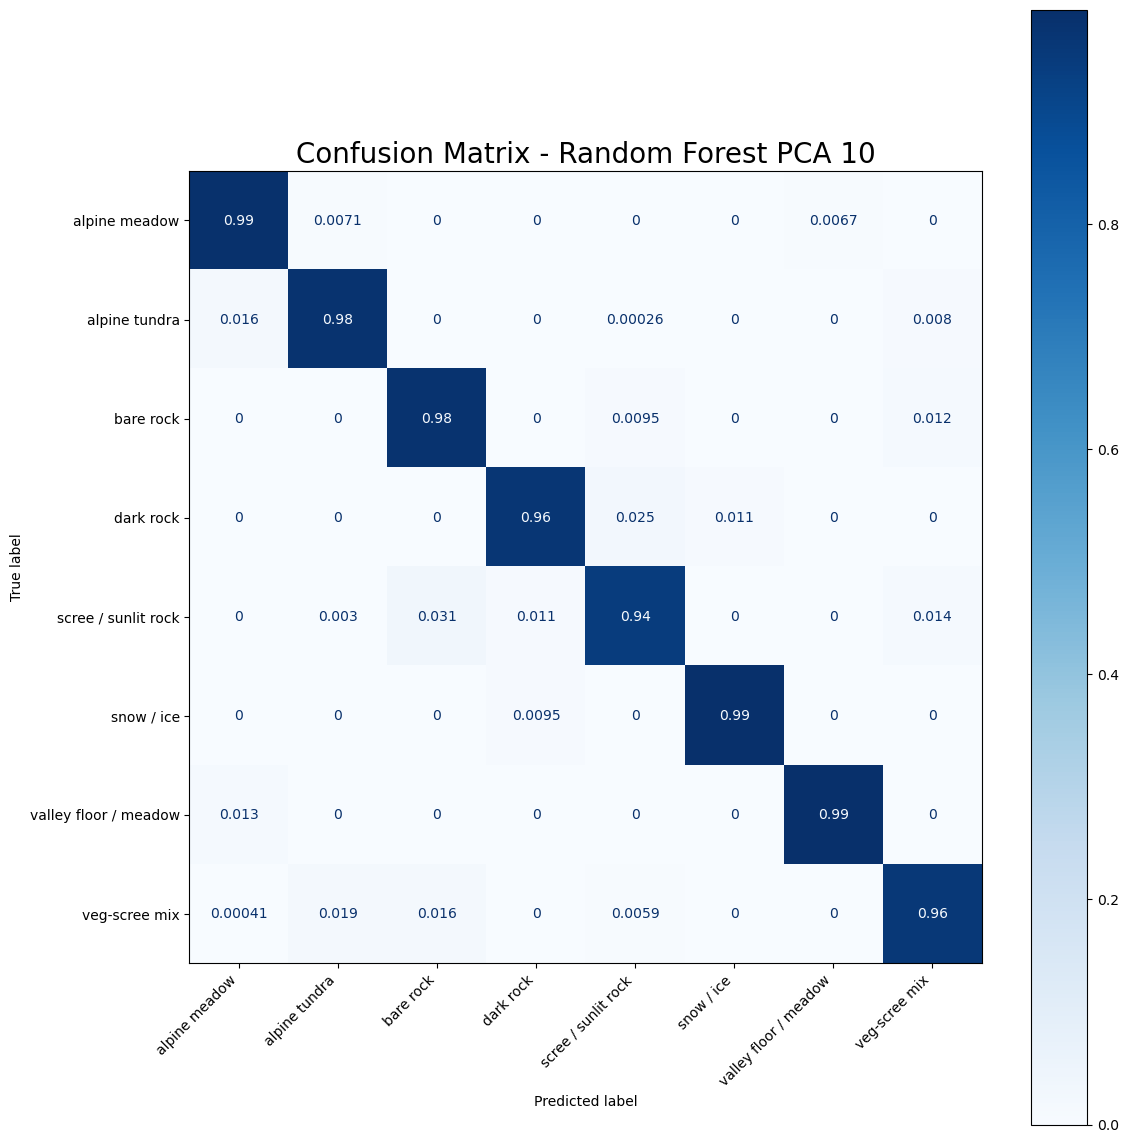

In [264]:
#PCA Random Forest confusion matrix
plot_confusion_matrix(y_test_encoded, df_predictions_pca["RF_PCA10"], le.classes_, "true", "Random Forest PCA 10")

Confusion Matrix for GBDT.

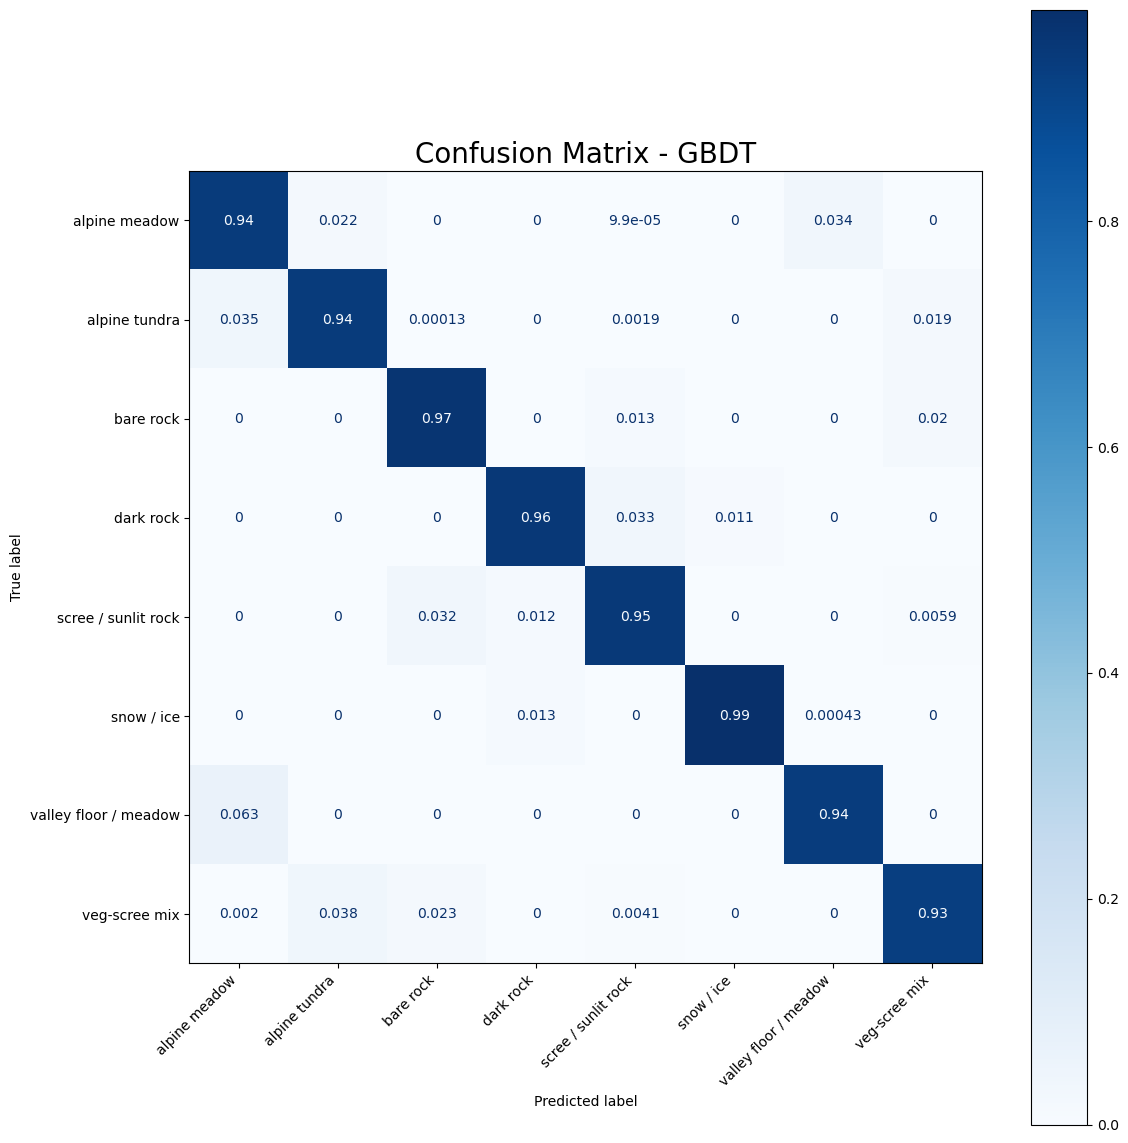

In [265]:
#Raw GBDT confusion matrix
plot_confusion_matrix(y_test_encoded, df_predictions_raw["GBDT"], le.classes_, "true", "GBDT")

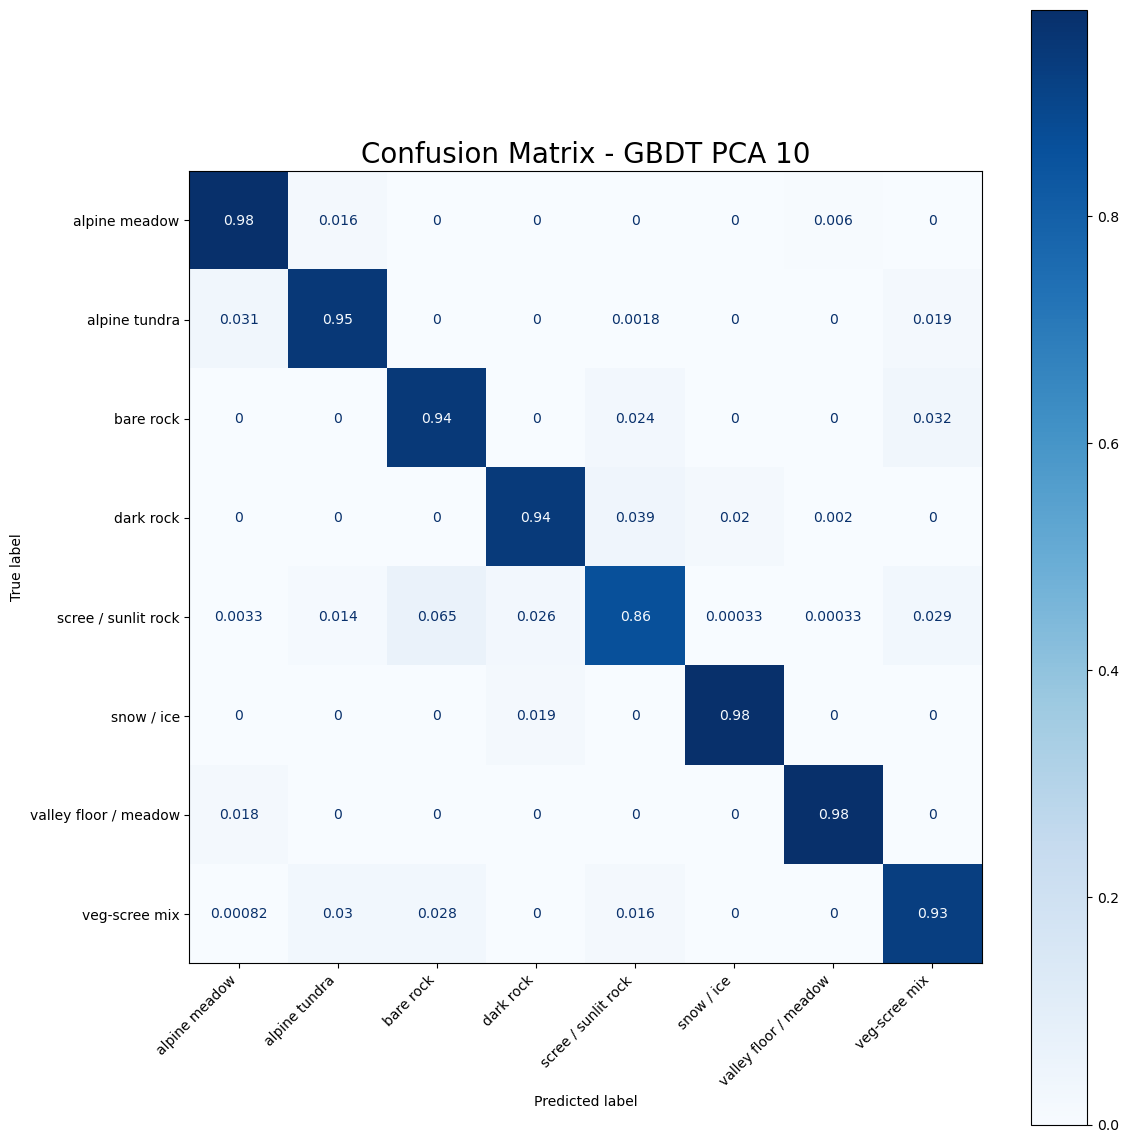

In [268]:
#PCA GBDT confusion matrix
plot_confusion_matrix(y_test_encoded, df_predictions_pca["GBDT_PCA10"], le.classes_, "true", "GBDT PCA 10")

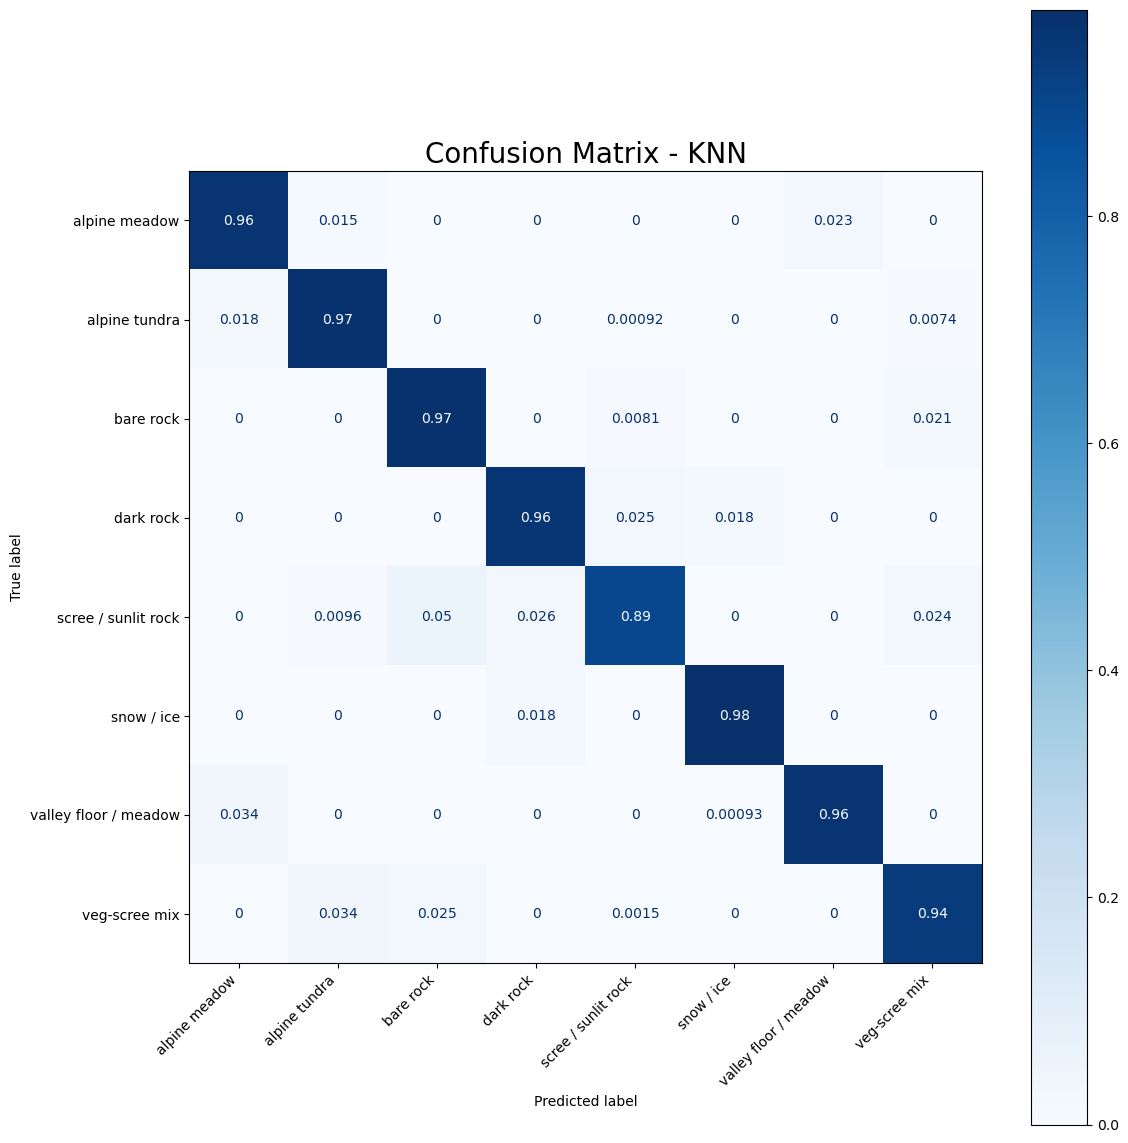

In [269]:
#KNN
plot_confusion_matrix(y_test_encoded_1, df_predictions_raw_1["KNN"], le_1.classes_, "true", "KNN")

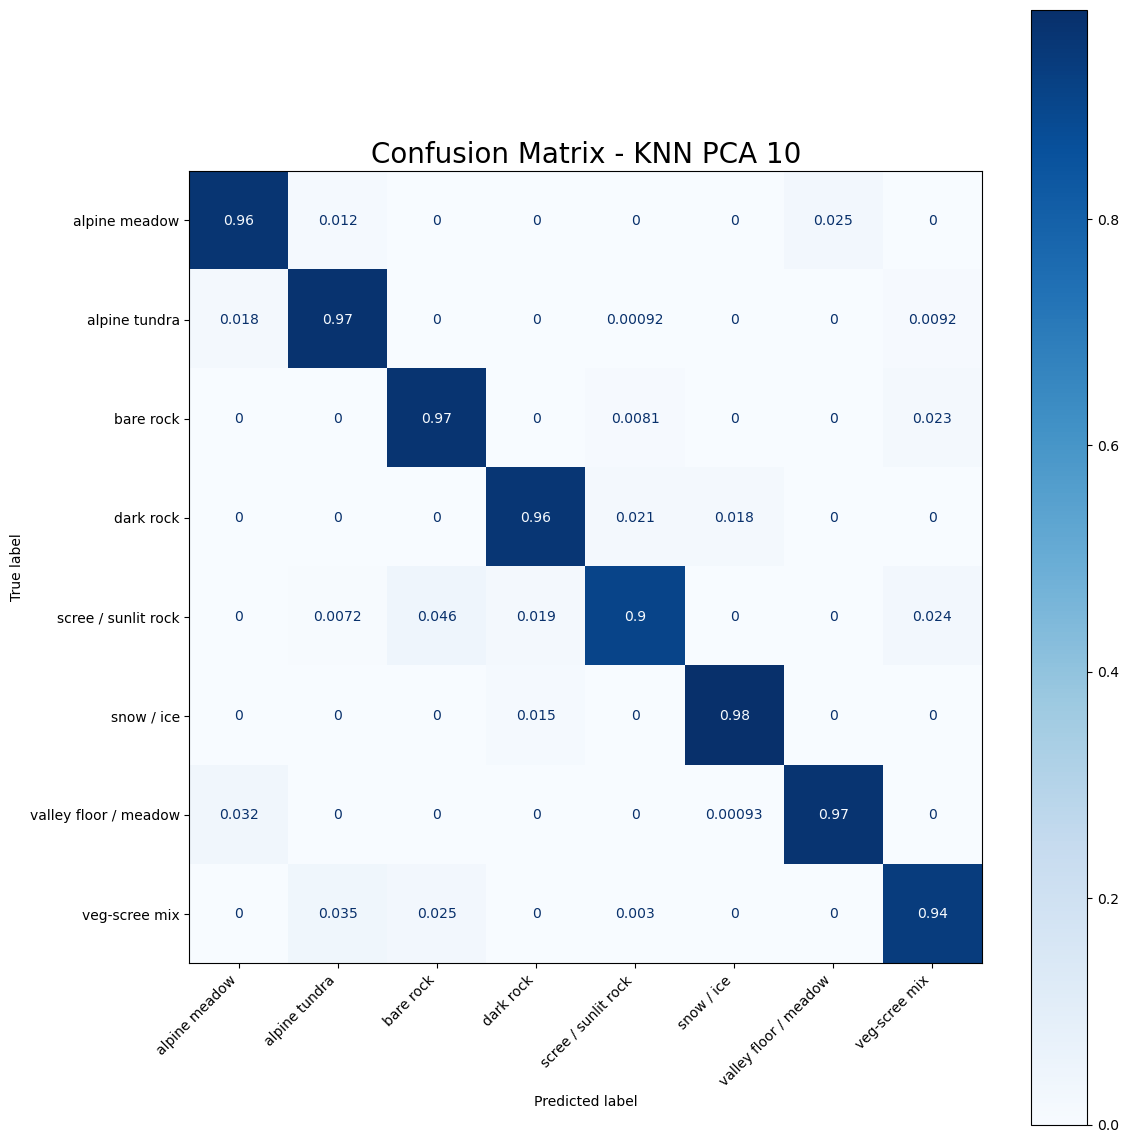

In [270]:
#KNN PCA10
plot_confusion_matrix(y_test_encoded_1, df_predictions_pca_1["KNN_PCA10"], le_1.classes_, "true", "KNN PCA 10")

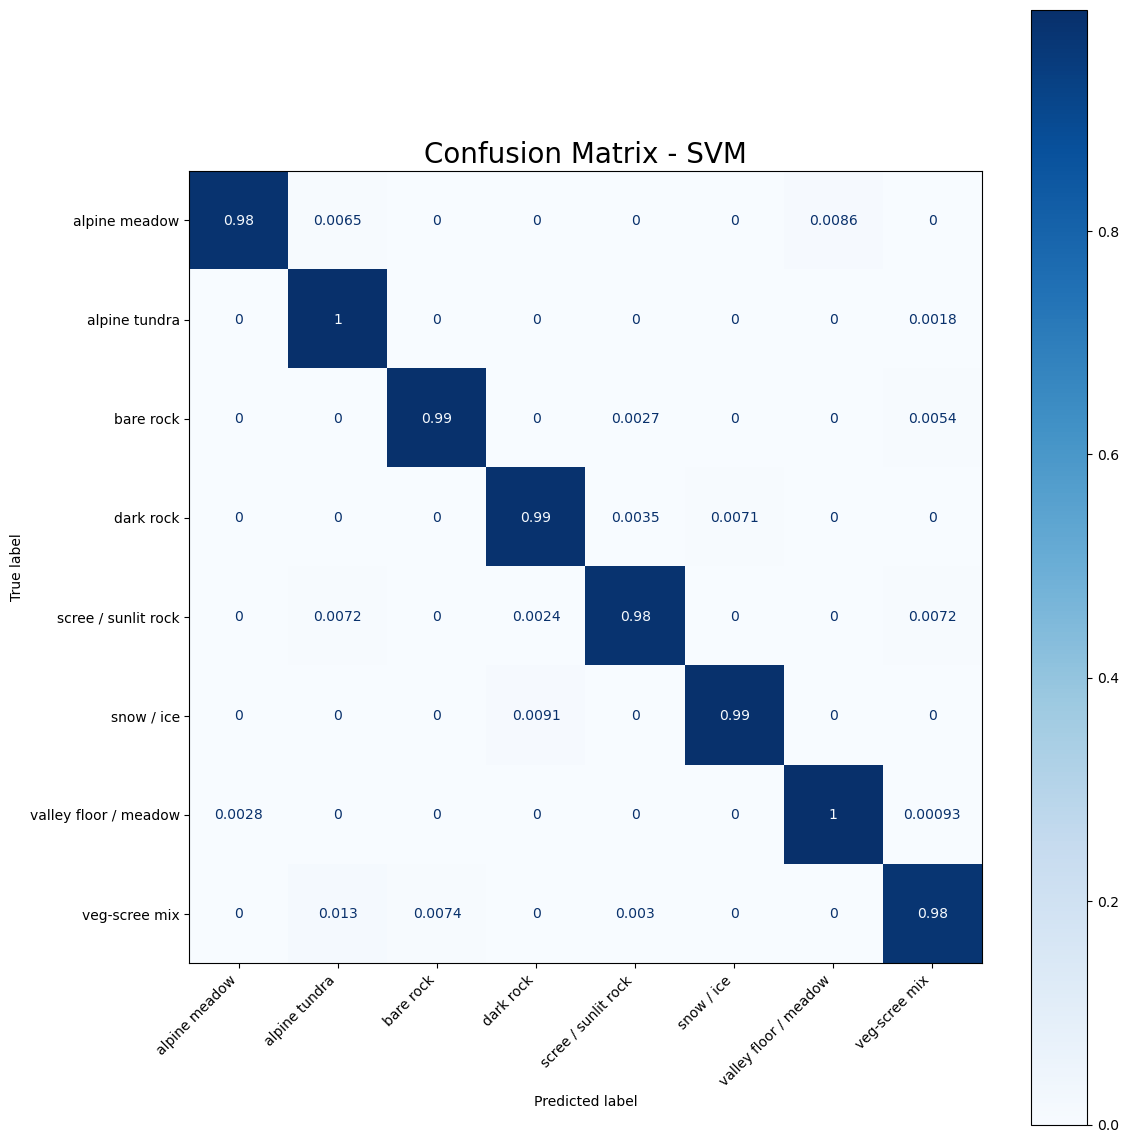

In [271]:
#SVM 
plot_confusion_matrix(y_test_encoded_1, df_predictions_raw_1["SVM"], le_1.classes_, "true", "SVM")

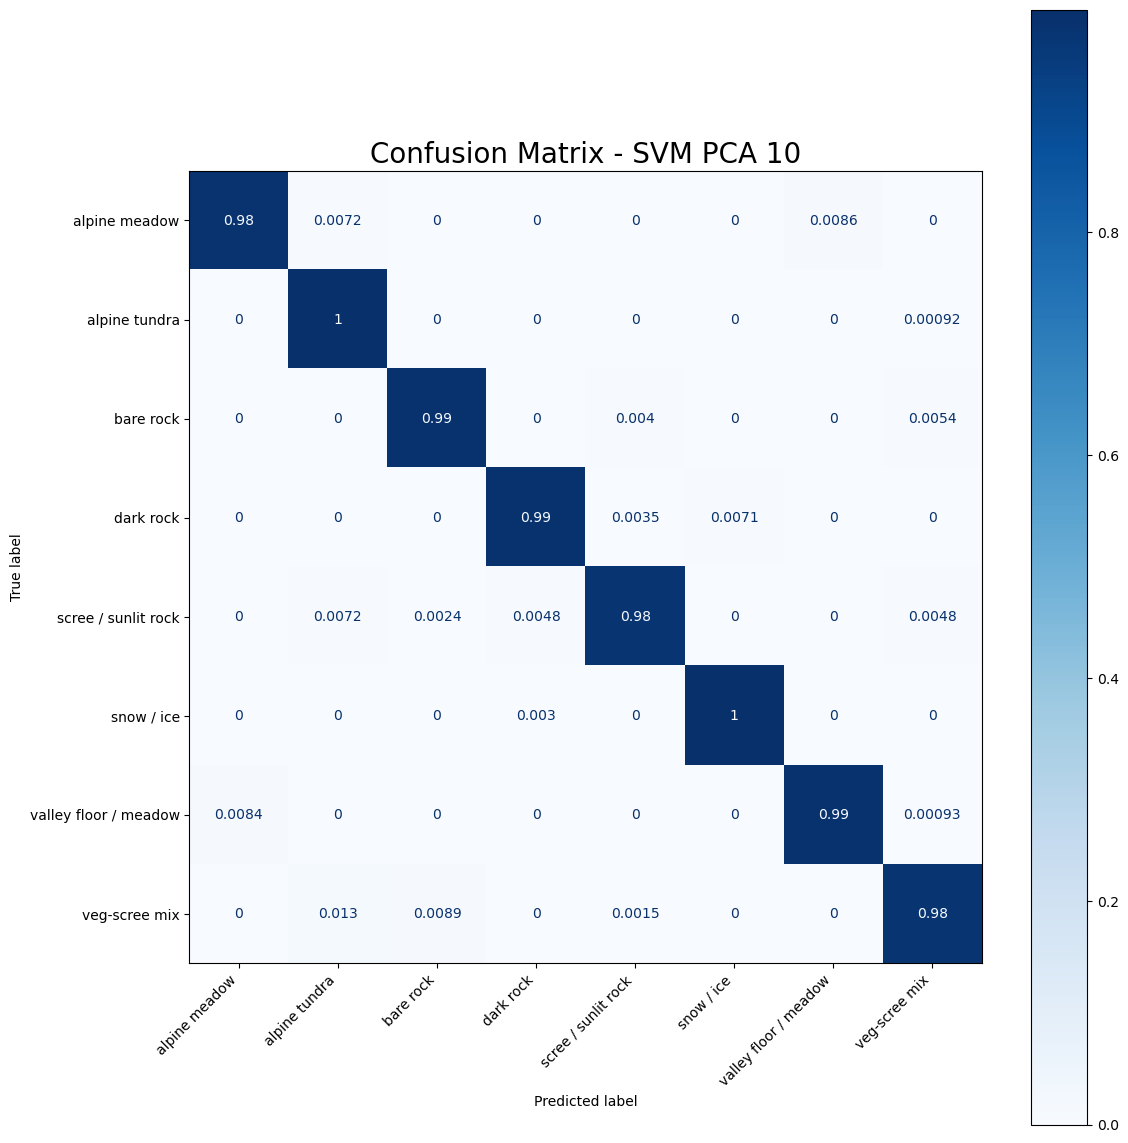

In [272]:
# SVM PCA10
plot_confusion_matrix(y_test_encoded_1, df_predictions_pca_1["SVM_PCA10"], le_1.classes_, "true", "SVM PCA 10")

#### Some observations worth noting:

We can see that the classifiers have very high performance on this dataset, despite its large size. One possible reasons is due to the fact that in image recognition the signal to noise ratio is very high, as compared to, for example, financial time series, where the signal to noise ratio is low.